<a href="https://colab.research.google.com/github/Harm1995/CTA-sensitivity/blob/master/additional_code/likelihood_quadratic_appox_spectra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The packages

In [ ]:
try:
  import iminuit
  from iminuit import Minuit

except:
  !pip install iminuit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random
import scipy
from scipy.stats import norm
import astropy
from astropy.io import fits
import seaborn as sns
import time
from tqdm.auto import tqdm, trange
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection




time = 1

In [ ]:
roi = 5                       ## Our range of interest in degrees
TeV = 10**-6                  ## Convertion rate
energy_start_bin = 3
offset = 0                    ## The offset of the telescope. We assume we look at the target directly
pre_normalisation = 1
energy_bin = 0

parsec = 3.08567758 * 10**18
Sun_to_centrum = 8122 * parsec

In [ ]:
## The Energy is saved as a tuple, via this way we make it a normal list

ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"
energy_list1 = np.array(fits.getdata(ring_path + 'ics_ring_1.fits', ext=1))
energies = []
for energy in energy_list1:
    E = float(str(energy)[1:-2])
    energies.append(E)
energies = np.array(energies)
energies = energies * TeV   


# Data

## The raw data

### Original model

In [ ]:
pre_path = "/content/drive/My Drive/Colab Notebooks/master_project/"
ring_path = "/content/drive/My Drive/Colab Notebooks/master_project/rings_background/"


### Here we get the diffusive emission maps:
ics_ring_maps = []
GCE_ring_maps = []
for i in range(1,5):
  ics = np.roll(fits.getdata(ring_path + 'ics_ring_'+str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  brems = np.roll(fits.getdata(ring_path + 'bremss_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  pion = np.roll(fits.getdata(ring_path + 'pion_ring_'+ str(i) +'_new.fits', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  ics_ring_maps.append(ics)
  GCE_ring_maps.append(brems + pion)

GDE_maps = []
GDE_maps.append(ics_ring_maps)
GDE_maps.append(GCE_ring_maps)
GDE_maps = np.array(GDE_maps)

tot_ics = np.array(ics_ring_maps[0] + ics_ring_maps[1] + ics_ring_maps[2] + ics_ring_maps[3])
tot_gce = np.array(GCE_ring_maps[0] + GCE_ring_maps[1] + GCE_ring_maps[2] + GCE_ring_maps[3])


### GCE extrapolated from fermi

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/data_txt_files/"

df_ics = pd.read_table(path+ 'ICS_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

df_gce = pd.read_table(path+ 'GasCorrelated_spectra_40x40_roi_Abazajian_etal_2020.dat', skiprows=1, sep = ' '
  , header = None,  names= ['Emin', 'Emax','Ecenter',  'E^2dN/dE', 'error'])

Fermi_eneriges_ics = df_ics['Ecenter'] /1000
Fermi_flux_ics = df_ics['E^2dN/dE']/1000
error1 = df_ics['error']/1000

Fermi_eneriges_gce = df_gce['Ecenter']/1000
Fermi_flux_gce = df_gce['E^2dN/dE']/1000
error2 = df_gce['error']/1000

def func(E, *param):
  return (param[0] * E**-param[1])

param,errors = scipy.optimize.curve_fit(func,Fermi_eneriges_gce, Fermi_flux_gce,p0 = [[10**-8,2]])
fit_func1 = [func(E,*param) for E in Fermi_eneriges_gce]
fit_func2 = [func(E,*param) for E in energies]

energy_bin = 10
GCE_ring_1_temp = GCE_ring_maps[0][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_2_temp = GCE_ring_maps[1][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_3_temp = GCE_ring_maps[2][energy_bin] / np.mean(tot_gce[energy_bin]) 
GCE_ring_4_temp = GCE_ring_maps[3][energy_bin] / np.mean(tot_gce[energy_bin]) 

new_GCE_1 = []
new_GCE_2 = []
new_GCE_3 = []
new_GCE_4 = []

param2 = [param[0], param[1] +2]
for E in energies:
  new_GCE_1.append(GCE_ring_1_temp * func(E, *param2))
  new_GCE_2.append(GCE_ring_2_temp * func(E, *param2))
  new_GCE_3.append(GCE_ring_3_temp * func(E, *param2))
  new_GCE_4.append(GCE_ring_4_temp * func(E, *param2))

new_GCE_1 = np.array(new_GCE_1)
new_GCE_2 = np.array(new_GCE_2)
new_GCE_3 = np.array(new_GCE_3)
new_GCE_4 = np.array(new_GCE_4)

tot_new_GCE = new_GCE_1 + new_GCE_2 + new_GCE_3 + new_GCE_4 

### The fermi maps

In [ ]:
fermi_map = fits.getdata(pre_path + 'fig12_bubbles_template_3compSCA_40x40deg_inpaint.fits')[(40 - 2*roi):(40 + 2 * roi),(40 - 2*roi):(40 + 2 * roi)]
fermi_map = fermi_map / np.mean(fermi_map)

def fermi_function_min(E):
  phi0 = 0.5 * 10**-8
  sigma = 1.9
  E_co = 1

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq

def fermi_function_max(E):
  phi0 = 1 * 10**-8
  sigma = 1.9
  E_co = 20

  fluxq = phi0 * np.exp(-E/E_co) * E**-sigma
  return fluxq


fermi_binned_min = []
fermi_binned_max = []

for E in energies:
  fermi_binned_min.append(fermi_map * fermi_function_min(E))
  fermi_binned_max.append(fermi_map * fermi_function_max(E))


fermi_binned_min = np.array(fermi_binned_min)
fermi_binned_max = np.array(fermi_binned_max)



### Alternative model

In [ ]:
pre_path_alt = '/content/drive/My Drive/Colab Notebooks/master_project/Alternative_GDE/'

dust_pos =fits.getdata(pre_path_alt + 'DustPositive_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
dust_neg =fits.getdata(pre_path_alt + 'DustNegative_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]

dust_neg = np.array(dust_neg)
dust_pos = np.array(dust_pos)



H1_maps = []
H2_maps = []
for ring in range(1,5):
  map_H2 = fits.getdata(pre_path_alt + f'H2_pohl_ring_{ring}_Normalized.fits')[(40 - roi * 2):(40 + roi * 2), (40 - roi * 2):(40 + roi * 2)]
  map_H1 = fits.getdata(pre_path_alt + f'HI_pohl_T150K_ring_{ring}_Normalized.fits')[(180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  H1_maps.append(map_H1)
  H2_maps.append(map_H2)


initial_norm_factor = (np.sum(H1_maps) + np.sum(H2_maps) + np.sum(dust_neg + dust_pos) ) / np.sum(GCE_ring_maps) 


H1_norm = []
H2_norm = []
dust_pos_norm = dust_pos / initial_norm_factor
dust_neg_norm = dust_neg / initial_norm_factor

for i in range(0,4):
  H1_norm.append(H1_maps[i] / initial_norm_factor )
  H2_norm.append(H1_maps[i] / initial_norm_factor )
import scipy

tot_alter = np.sum(H1_maps) + np.sum(H1_maps) + np.sum(dust_pos)+ np.sum(dust_neg) 
sum_gce = np.sum(tot_gce)

l2 = []
for i in range(47):
  l2.append(np.sum(tot_gce[i]))

def func(E,a,b,c):
  return (a * (E/b)**-c)

p1,p2 = scipy.optimize.curve_fit(func,energies, l2)


norm_factor = sum_gce / tot_alter

def func(E):
  b = float(0.2)
  c = float(2.5)

  return ((E/b)**-c * norm_factor *10**-3.8)



H1_1_binned = []
H1_2_binned = []
H1_3_binned = []
H1_4_binned = []

H2_1_binned = []
H2_2_binned = []
H2_3_binned = []
H2_4_binned = []

dust_binned_pos = []
dust_binned_neg = []

for E in energies:
  H1_1_binned.append(H1_maps[0] * func(E))
  H1_2_binned.append(H1_maps[1] * func(E))
  H1_3_binned.append(H1_maps[2] * func(E))
  H1_4_binned.append(H1_maps[3] * func(E))

  H2_1_binned.append(H2_maps[0] * func(E))
  H2_2_binned.append(H2_maps[1] * func(E))
  H2_3_binned.append(H2_maps[2] * func(E))
  H2_4_binned.append(H2_maps[3] * func(E))

  dust_binned_pos.append(dust_pos * func(E))
  dust_binned_neg.append(dust_neg * func(E))

tot_alt = [H1_1_binned,H1_2_binned, H1_3_binned, H1_4_binned, H2_1_binned,H2_2_binned, H2_3_binned, H2_4_binned,dust_binned_pos,dust_binned_neg]
tot_alt = np.array(tot_alt)

tot_gce_alt = np.sum(tot_alt, axis = 0)


H1_1_binned = np.array(H1_1_binned)
H1_2_binned = np.array(H1_2_binned)
H1_3_binned = np.array(H1_3_binned)
H1_4_binned = np.array(H1_4_binned)

H2_1_binned = np.array(H2_1_binned)
H2_2_binned = np.array(H2_2_binned)
H2_3_binned = np.array(H2_3_binned)
H2_4_binned = np.array(H2_4_binned)

dust_binned_pos = np.array(dust_binned_pos)
dust_binned_neg = np.array(dust_binned_neg)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power


### Signal maps

In [ ]:
path_to_signal = '/content/drive/My Drive/Colab Notebooks/data_txt_files/NB_and_F98/'

NB_ring_maps = []
F98_ring_maps = []

for i in range(0,5):
  NB_map = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_F98bar_inj' + str(i) +'.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  F98_map = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_NB_inj' + str(i) +'.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]
  NB_ring_maps.append(NB_map)
  F98_ring_maps.append(F98_map)


NB_ring_maps = np.array(NB_ring_maps)
F98_ring_maps = np.array(F98_ring_maps)

signals = NB_ring_maps + F98_ring_maps


In [ ]:
dark_matter = np.roll(fits.getdata(path_to_signal + 'ics_anisotropic_mapcube_56_NFW_inj0.gz', ext=0), 360, axis=2)[:, (180 - roi * 2):(180 + roi * 2), (360 - roi * 2):(360 + roi * 2)]

dark_matter = np.array(dark_matter)


We have the following Background flux maps

* 4 rings of ics maps 47 * 20 * 20
* 4 rings of GCE maps 47 * 20 * 20
* 1 Fermi min map 47 * 20 * 20
* 1 Fermi max map 47 * 20 * 20

An alternative GCE map extrapolated from Fermi dataL

* 4 rings of GCE maps 47 * 20 * 20


And for the alternative model:

* 4 ring maps H1 40 * 40
* 4 ring maps H2 40 * 40
* 2 dust maps 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 47 * 20 * 20
* 5  injection spectra F98 map 47 * 20 * 20

## Convolved data

In [ ]:
files_paths = '/content/drive/My Drive/Colab Notebooks/data_txt_files/'

orig_shape = (9, 47, 20, 20)
original_file = files_paths + 'Model_new.txt.txt'
simulated_backgrounds = np.loadtxt(original_file).reshape(orig_shape)

ics_rings = np.loadtxt(files_paths + 'ice_file.txt').reshape(4,46,20,20)
gce_rings = np.loadtxt(files_paths + 'gce_file.txt').reshape(4,46,20,20)
gce2_rings = np.loadtxt(files_paths + 'gce2_file.txt').reshape(4,46,20,20)
NB_rings = np.loadtxt(files_paths + 'NB_file.txt').reshape(5,46,20,20)
F98_rings = np.loadtxt(files_paths + 'F98_file.txt').reshape(5,46,20,20)
signal_rings = np.loadtxt(files_paths + 'signal_file.txt').reshape(5,46,20,20)
alternative_gce = np.loadtxt(files_paths + 'Alternative_gce.txt').reshape(10,46,20,20)
fermi_maps = np.loadtxt(files_paths + 'fermi_map').reshape(2,46,20,20)
fermi_bubble = simulated_backgrounds[-1][:-1] * 137
dark_matter_map = np.loadtxt(files_paths + 'dark_matter_map').reshape(46,20,20)


signal_inj_list = signal_rings
all_backgrounds = np.array([ics_rings[0], ics_rings[1], ics_rings[2], ics_rings[3], gce_rings[0], gce_rings[1], gce_rings[2], gce_rings[3],fermi_bubble])


We have the following Background Count maps

* 4 rings of ics maps 46 * 20 * 20
* 4 rings of GCE maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20


And for the alternative model:


* 4 ring maps H1 46 * 40 * 40
* 4 ring maps H2 46 * 40 * 40
* 4 rings of ics 46 * 20 * 20
* 2 dust maps 46 * 20 * 20
* 2 Fermi maps 46 * 20 * 20

And the Following signal - maps:

* 5  injection spectra NB signal map 46 * 20 * 20
* 5  injection spectra F98 map 46 * 20 * 20

###Alternative mask matrix

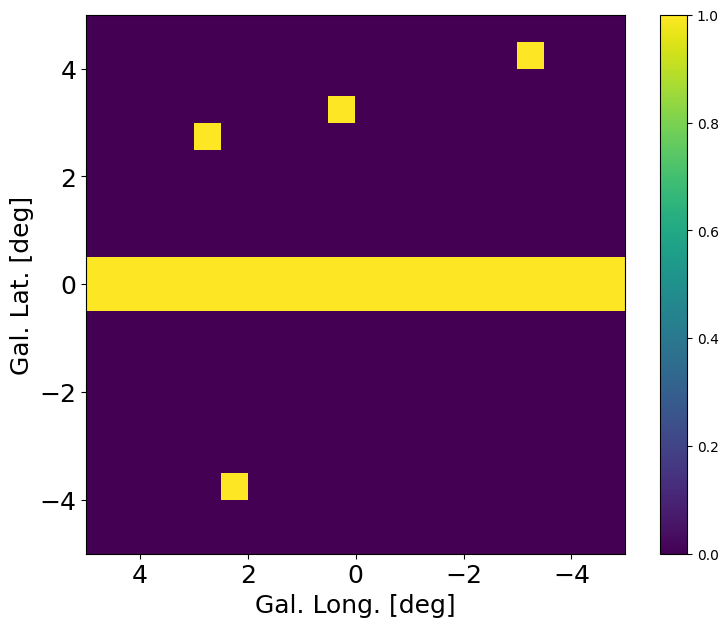

In [ ]:
def mask_matrix_fu():

  catalog = fits.open(pre_path + 'gll_psch_v13.fit')

  ptsrc_long = []
  ptsrc_lat = []

  # Here is load all the point sources in our range of interest:
  for i in range(len(catalog[1].data)):
      if(catalog[1].data[i][9] > 4.0 and catalog[1].data[i][33] == ''):
          if(-roi + 180 <= catalog[1].data[i][3] <= roi + 180):
              if(-roi <= catalog[1].data[i][4] <= roi):
                  ptsrc_long.append(catalog[1].data[i][3])
                  ptsrc_lat.append(catalog[1].data[i][4])

  # Here I make a matrix that has a zero on all the positions that are +/- 0.25 degrees away from
  # a Fermi high energy source. Also the galactic ridge (+/- 0.3 degrees lattitude) are maskt.
  mask_matrix = []
  y_coor = 0
  x_min = 180 - roi
  x_max = 180 + roi
  y_min = - roi
  y_max = roi
  y_steps = 4 * roi
  x_steps = 4 * roi

  for y in np.linspace(y_max, y_min, y_steps):
      mask_matrix.append([])
      for x in np.linspace(x_min, x_max, x_steps):
          mark = 0
          for i in range(len(ptsrc_long)):
              ps_x = ptsrc_long[i]
              ps_y = ptsrc_lat[i]
              if abs(ps_x - x) < 0.25:
                  if abs(ps_y - y) < 0.25:
                      mark = 1
                      break
  #            if ((ps_x - x)**2 + (ps_y - y)**2)**0.5  < 0.25:
  #                mark = 0
          if abs(y) < 0.3:
              mark = 1
          mask_matrix[y_coor].append(mark)
      y_coor += 1

  mask_matrix = np.array(mask_matrix)
  return mask_matrix

mask_matrix = mask_matrix_fu()






mask2 = []

for i in range(11):
  mask2.append(mask_matrix)

mask2 = np.array(mask2)

plt.figure(figsize=(9,7))
plt.xlabel("Gal. Long. [deg]",fontsize=18)
plt.ylabel("Gal. Lat. [deg]",fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.imshow(mask2[0], extent = [roi,-roi,-roi,roi])
plt.colorbar()
plt.show()


## Compressing again to 11 rings

In [ ]:
Ics_ring_1_template = []
Ics_ring_2_template = []
Ics_ring_3_template = []
Ics_ring_4_template = []
GCE_ring_1_template = []
GCE_ring_2_template = []
GCE_ring_3_template = []
GCE_ring_4_template = []

fermi_template = []

signal_0_template = []
signal_1_template = []
signal_2_template = []
signal_3_template = []
signal_4_template = []


H1_ring_1_template = []
H1_ring_2_template = []
H1_ring_3_template = []
H1_ring_4_template = []

H2_ring_1_template = []
H2_ring_2_template = []
H2_ring_3_template = []
H2_ring_4_template = []

dust_pos_template = []
dust_neg_template = []

dark_matter_template = []

new_energies = []

for j in range(0,11):
  i = 2+j*4
  new_energies.append(energies[i])


  Ics_ring_1_template.append(np.sum(ics_rings[0][i:i+4], axis = 0))
  Ics_ring_2_template.append(np.sum(ics_rings[1][i:i+4], axis = 0))
  Ics_ring_3_template.append(np.sum(ics_rings[2][i:i+4], axis = 0))
  Ics_ring_4_template.append(np.sum(ics_rings[3][i:i+4], axis = 0))

  GCE_ring_1_template.append(np.sum(gce_rings[0][i:i+4], axis = 0))
  GCE_ring_2_template.append(np.sum(gce_rings[1][i:i+4], axis = 0))
  GCE_ring_3_template.append(np.sum(gce_rings[2][i:i+4], axis = 0))
  GCE_ring_4_template.append(np.sum(gce_rings[3][i:i+4], axis = 0))

  fermi_template.append(np.sum(fermi_maps[0][i:i+4], axis = 0))

  signal_0_template.append(np.sum(signal_rings[0][i:i+4], axis = 0))
  signal_1_template.append(np.sum(signal_rings[1][i:i+4], axis = 0))
  signal_2_template.append(np.sum(signal_rings[2][i:i+4], axis = 0))
  signal_3_template.append(np.sum(signal_rings[3][i:i+4], axis = 0))
  signal_4_template.append(np.sum(signal_rings[4][i:i+4], axis = 0))

  dark_matter_template.append(np.sum(dark_matter_map[i:i+4], axis = 0))


  H1_ring_1_template.append(np.sum(alternative_gce[0][i:i+4], axis = 0))
  H1_ring_2_template.append(np.sum(alternative_gce[1][i:i+4], axis = 0))
  H1_ring_3_template.append(np.sum(alternative_gce[2][i:i+4], axis = 0))
  H1_ring_4_template.append(np.sum(alternative_gce[3][i:i+4], axis = 0))

  H2_ring_1_template.append(np.sum(alternative_gce[4][i:i+4], axis = 0))
  H2_ring_2_template.append(np.sum(alternative_gce[5][i:i+4], axis = 0))
  H2_ring_3_template.append(np.sum(alternative_gce[6][i:i+4], axis = 0))
  H2_ring_4_template.append(np.sum(alternative_gce[7][i:i+4], axis = 0))

  dust_pos_template.append(np.sum(alternative_gce[8][i:i+4], axis = 0))
  dust_neg_template.append(np.sum(alternative_gce[9][i:i+4], axis = 0))



Ics_ring_1_template = np.array(Ics_ring_1_template)
Ics_ring_2_template = np.array(Ics_ring_2_template)
Ics_ring_3_template = np.array(Ics_ring_3_template)
Ics_ring_4_template = np.array(Ics_ring_4_template)
GCE_ring_1_template = np.array(GCE_ring_1_template)
GCE_ring_2_template = np.array(GCE_ring_2_template)
GCE_ring_3_template = np.array(GCE_ring_3_template)
GCE_ring_4_template = np.array(GCE_ring_4_template)

fermi_template = np.array(fermi_template)

signal_0_template = np.array(signal_0_template)
signal_1_template = np.array(signal_1_template)
signal_2_template = np.array(signal_2_template)
signal_3_template = np.array(signal_3_template)
signal_4_template = np.array(signal_4_template)

signal_templates = np.array([signal_0_template, signal_1_template, signal_2_template, signal_3_template, signal_4_template])


H1_ring_1_template = np.array(H1_ring_1_template)
H1_ring_2_template = np.array(H1_ring_2_template)
H1_ring_3_template = np.array(H1_ring_3_template)
H1_ring_4_template = np.array(H1_ring_4_template)

H2_ring_1_template = np.array(H2_ring_1_template)
H2_ring_2_template = np.array(H2_ring_2_template)
H2_ring_3_template = np.array(H2_ring_3_template)
H2_ring_4_template = np.array(H2_ring_4_template)

dust_pos_template = np.array(dust_pos_template)
dust_neg_template = np.array(dust_neg_template)

dark_matter_template = np.array(dark_matter_template)

In [ ]:
dark_matter_template.shape

(11, 20, 20)

# Plotting the data

## The count maps

### Model 1

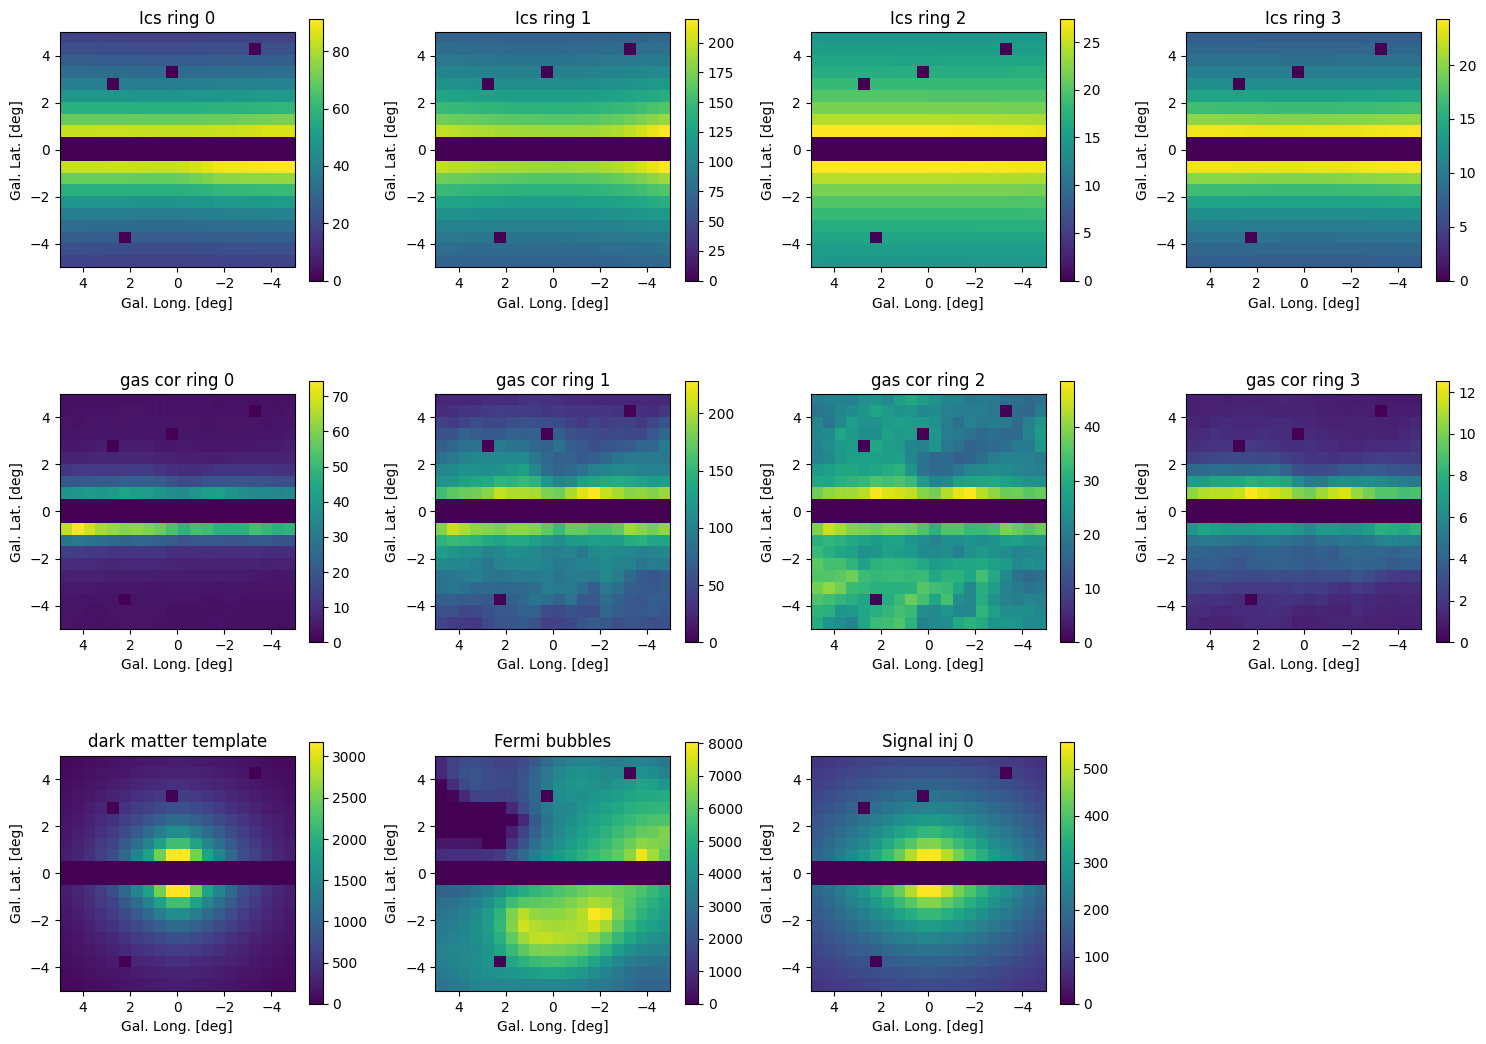

In [ ]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(3,4, figsize = (15,11))

sns.reset_defaults()

for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(gce_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'gas cor ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

plot = ax[2][1].imshow(fermi_maps[1][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[2][1], shrink = shrink)

plot = ax[2][2].imshow(signal_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[2][2], shrink = shrink)

plot = ax[2][0].imshow(dark_matter_map[energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][0].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'dark matter template')
fig.colorbar(plot, ax = ax[2][0], shrink = shrink)


fig.delaxes(ax[2][3])

fig.tight_layout()
plt.show()

### Model 2

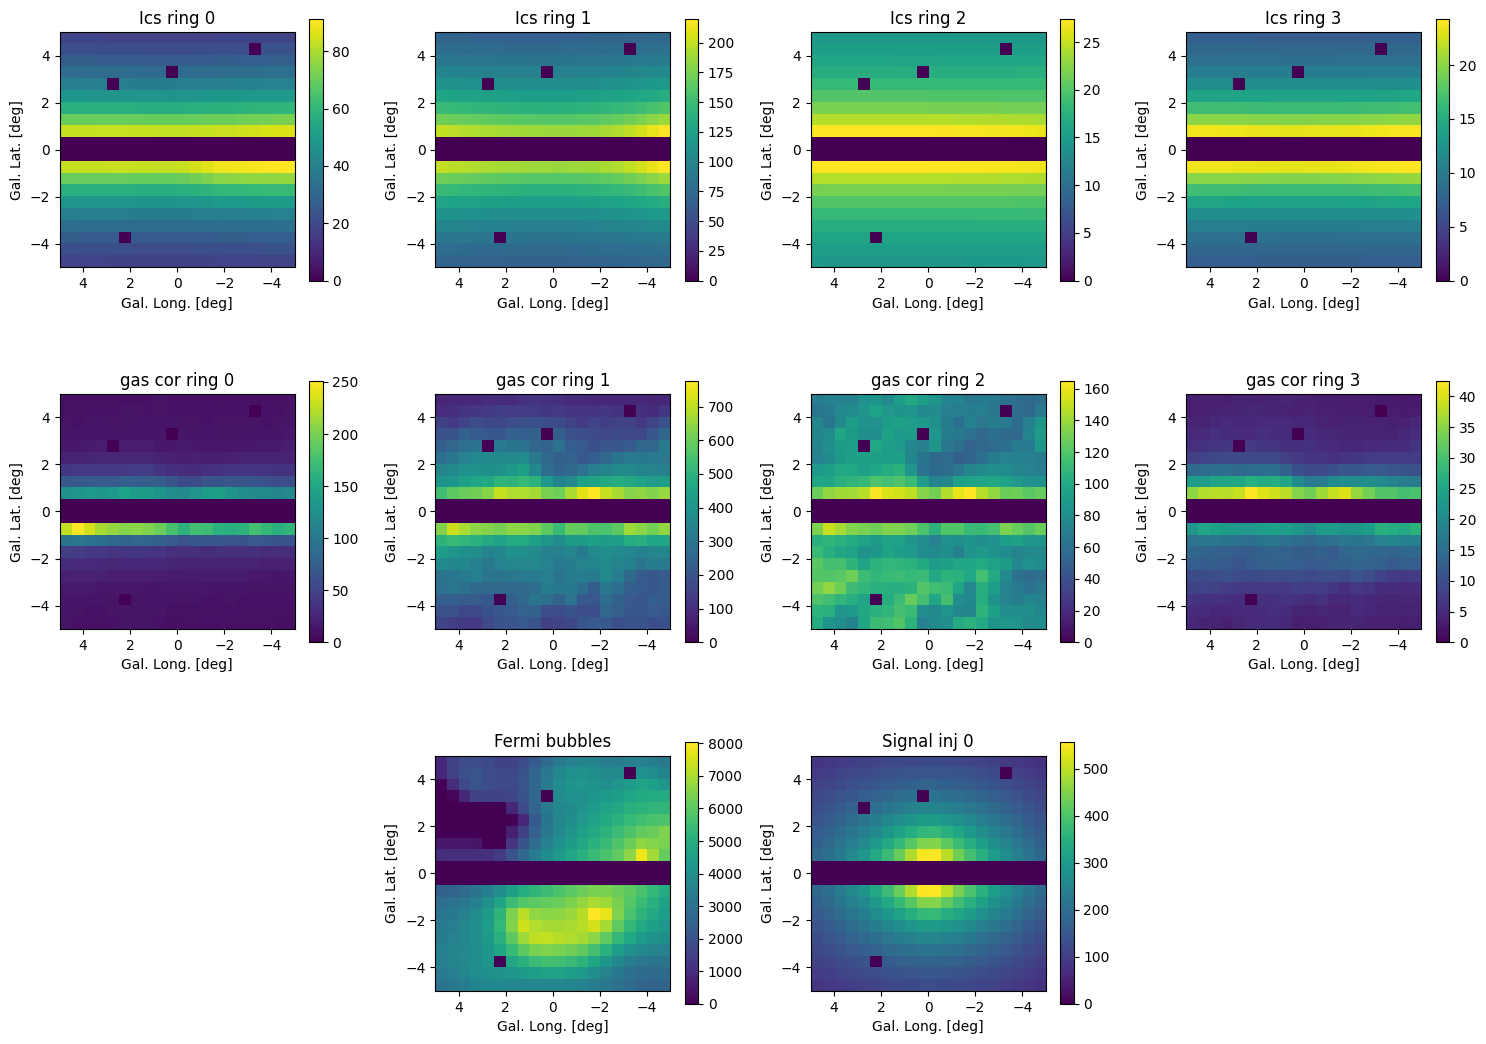

In [ ]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(3,4, figsize = (15,11))


for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(gce2_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'gas cor ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

plot = ax[2][1].imshow(fermi_maps[1][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[2][1], shrink = shrink)

plot = ax[2][2].imshow(signal_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[2][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[2][2], shrink = shrink)


fig.delaxes(ax[2][0])
fig.delaxes(ax[2][3])

fig.tight_layout()
plt.show()

### Model 3

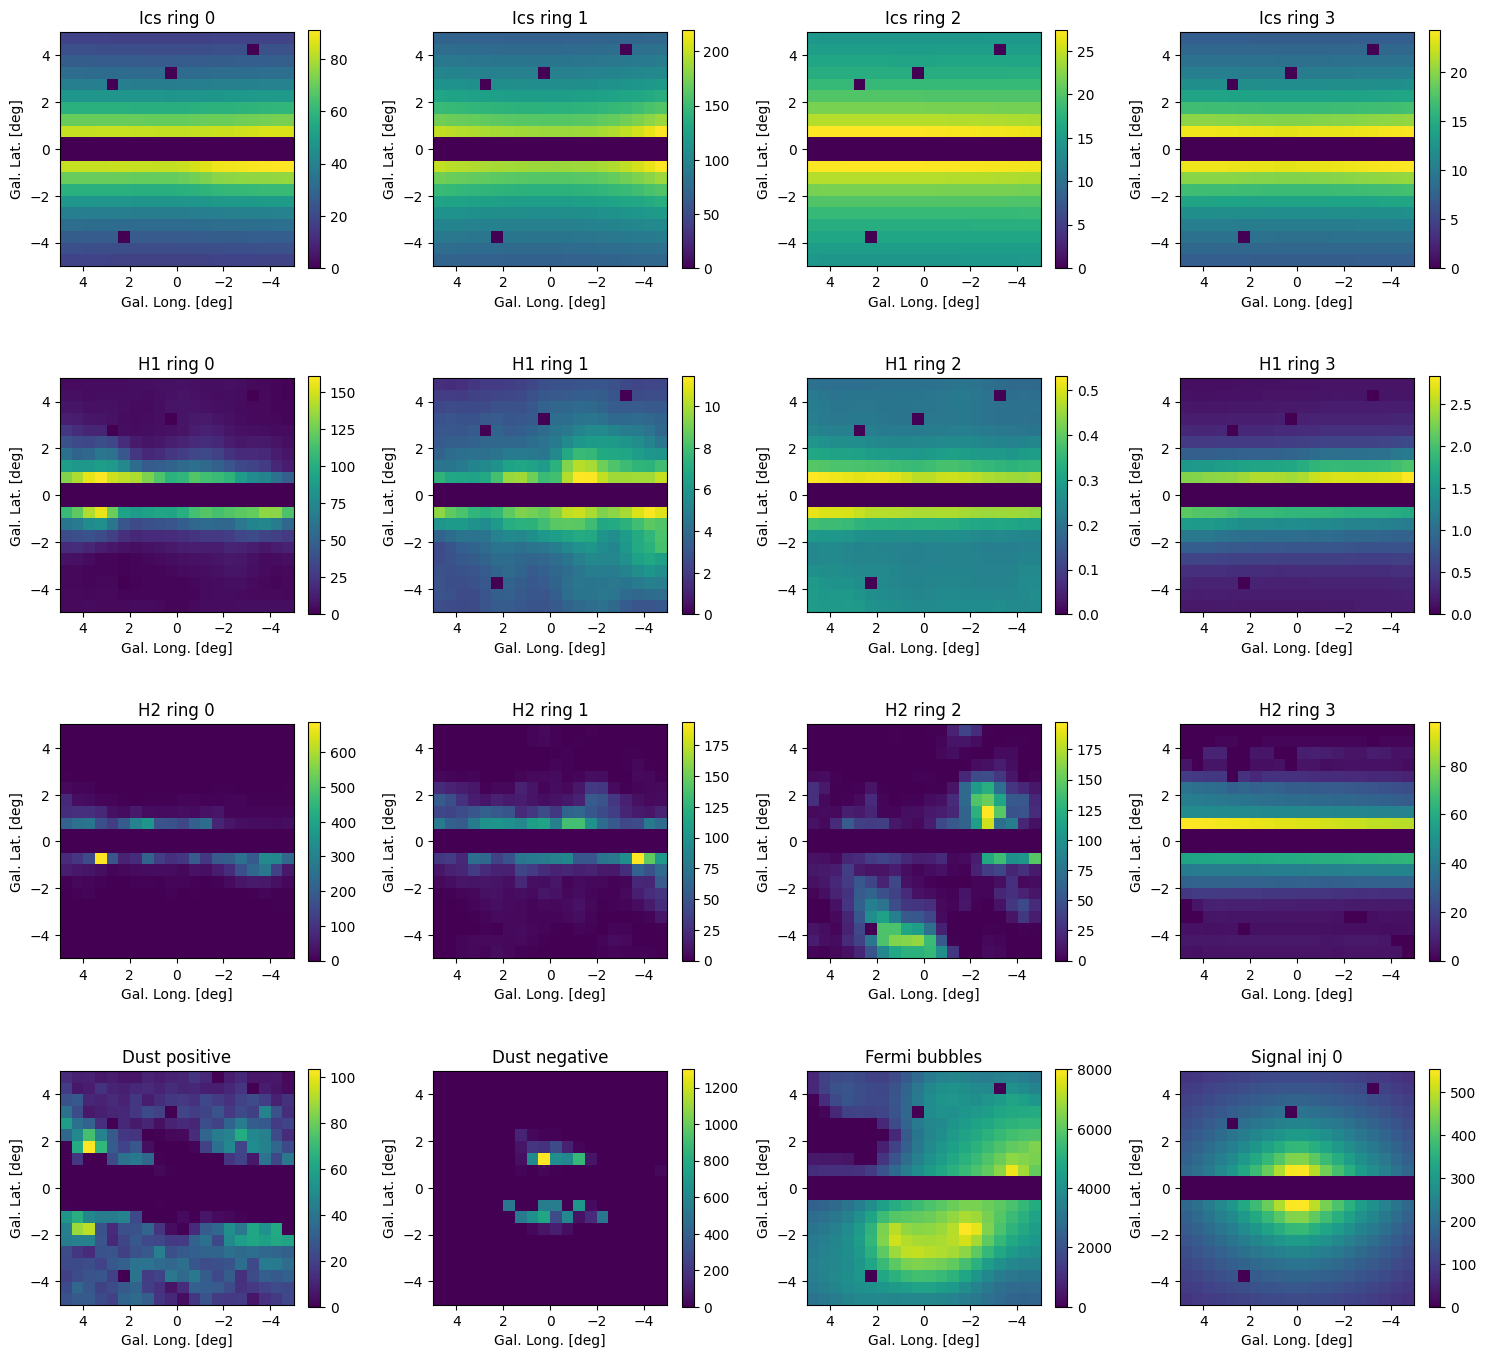

In [ ]:
energy_bin = 15
shrink = 0.8
fig,ax = plt.subplots(4,4, figsize = (15,14))


for i in range(4):
  plot = ax[0][i].imshow(ics_rings[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[0][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]", title = f'Ics ring {i}')
  fig.colorbar(plot, ax = ax[0][i], shrink = shrink)

for i in range(4):
  plot = ax[1][i].imshow(alternative_gce[i][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[1][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H1 ring {i}')
  fig.colorbar(plot, ax = ax[1][i], shrink = shrink)

for i in range(4):
  j = i+4
  plot = ax[2][i].imshow(alternative_gce[j][energy_bin], extent = [roi,-roi,-roi,roi])
  ax[2][i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'H2 ring {i}')
  fig.colorbar(plot, ax = ax[2][i], shrink = shrink)


plot = ax[3][0].imshow(alternative_gce[8][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][0].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust positive')
fig.colorbar(plot, ax = ax[3][0], shrink = shrink)

plot = ax[3][1].imshow(alternative_gce[9][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][1].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Dust negative')
fig.colorbar(plot, ax = ax[3][1], shrink = shrink)


plot = ax[3][2].imshow(fermi_maps[1][energy_bin] , extent = [roi,-roi,-roi,roi])
ax[3][2].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Fermi bubbles')
fig.colorbar(plot, ax = ax[3][2], shrink = shrink)

plot = ax[3][3].imshow(signal_rings[0][energy_bin], extent = [roi,-roi,-roi,roi])
ax[3][3].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Signal inj 0')
fig.colorbar(plot, ax = ax[3][3], shrink = shrink)


fig.tight_layout()
plt.show()

## The spectral shape

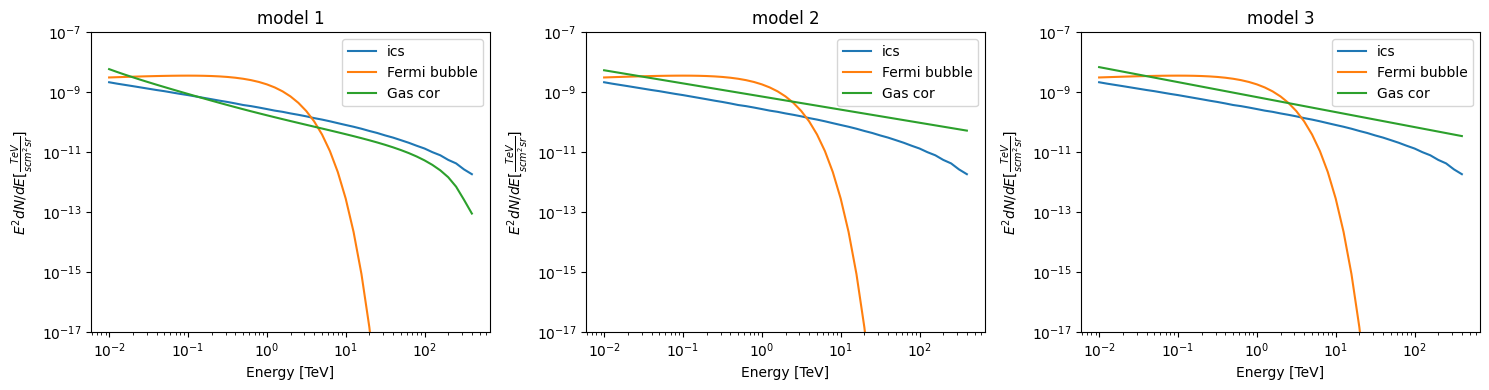

In [ ]:
ics_spectrum = [np.mean(tot_ics[i])*energies[i]**2 *10**6 for i in range(47)]
fermi_spectrum = [np.mean(fermi_binned_min[i]) * energies[i]**2 for i in range(47) ]

ics_gce1 = [np.mean(tot_gce[i])*energies[i]**2 *10**6 for i in range(47)]
ics_gce2 = [np.mean(tot_new_GCE[i])*energies[i]**2 for i in range(47)]
ics_gce3 = [np.mean(tot_gce_alt[i])*energies[i]**2*10**6 for i in range(47)]

fig, ax = plt.subplots(1,3, figsize = (15,4))

for i in range(3):
  ax[i].plot(energies, ics_spectrum, label = 'ics')
  ax[i].plot(energies, fermi_spectrum, label = 'Fermi bubble')
  ax[i].set(yscale= 'log', xscale= 'log',ylabel = r'$E^{2}dN/dE [\frac{TeV}{s cm^{2} sr}]$', xlabel = r'Energy [TeV]', title = f"model {i + 1}")
  ax[i].set_ylim(10**-17,10**-7)

ax[0].plot(energies, ics_gce1, label = 'Gas cor')
ax[1].plot(energies, ics_gce2, label = 'Gas cor')
ax[2].plot(energies, ics_gce3, label = 'Gas cor')

for i in range(3):
  ax[i].legend()


fig.tight_layout()

plt.show()



# Creating the synthetic data

### The parameters we use

In [ ]:
MC_times = 30                                     ### The amount of monte carlo simulations
ss_steps = 25                                     ### The amount of signal steps we use
signal_strengts = np.logspace(-1.5,0.1,ss_steps)      
injection_spectra = 1                             ### signal injection type 
sigma = 0.3                                       ### Error percentage on all background maps

### the sythentic data

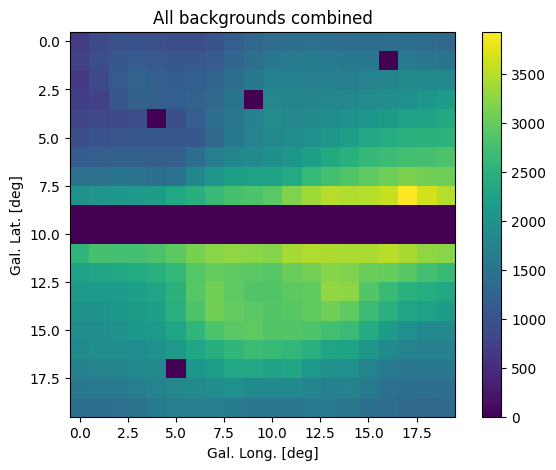

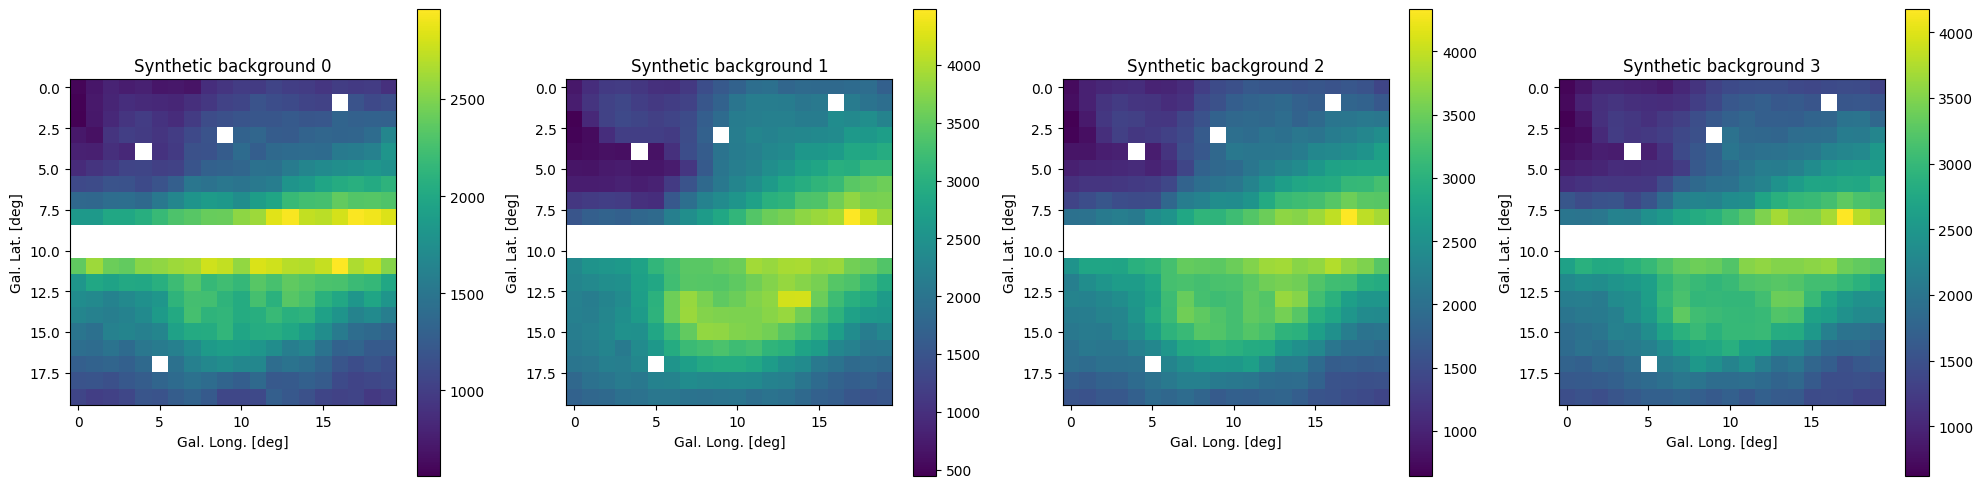

In [ ]:
all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
signal_conv = signal_templates[injection_spectra]
all_backgrounds = np.array(all_backgrounds)


def random_counts_with_signal(signal_strength,sigma, all_backgrounds, signal_conv):
  """  Function that creates a synthetic background map

  inputs:
  --------------
  sigma: 'float' The error percentage on all background maps
  all_backgrounds: 'n*20*20 array' array with all the different background maps
  signal_conv: '20*20 array' count map of the background signal

  output:
  --------------
  count matrix: '20*20 array' a synthetic data map for CTA
  """

  count_matrix = np.zeros(signal_conv.shape)
  for mapn in all_backgrounds:
    after_norm = np.random.normal(1, sigma) * mapn
    after_norm = after_norm.clip(0)
    count_matrix += after_norm
  signal_norm = signal_conv * signal_strength
  count_matrix += signal_norm

  count_matrix = np.random.poisson(count_matrix)
  return count_matrix


### Creating array with a range of simulated data 
all_simulated_background = []
for ss in signal_strengts:
  list_MC = []
  for _ in range(MC_times):
    a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)
    list_MC.append(np.ma.array(a, mask=mask2))    ### Mask the data
  all_simulated_background.append(list_MC)


## PLotting an example
fig,ax = plt.subplots(figsize = (7,5))
a = ax.imshow(np.sum(all_backgrounds, axis = 0)[0])
ax.set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'All backgrounds combined')
fig.colorbar(a, ax = ax)
plt.show()

fig,ax = plt.subplots(1,4,figsize = (20,5))

for i in range(4):
  a = ax[i].imshow(all_simulated_background[0][i][0])
  ax[i].set(xlabel = "Gal. Long. [deg]", ylabel = "Gal. Lat. [deg]",  title = f'Synthetic background {i}')
  fig.colorbar(a, ax = ax[i])

fig.tight_layout()

plt.show()



#The bin by bin analysis class

In [ ]:
class analysis:

  def __init__(self, signal_strength, model_backgrounds,signal1,data_map):
    self.signal_strength = signal_strength
    self.counts_m = data_map
    self.all_backgrounds = model_backgrounds
    self.signal_conv = signal1
    self.signal1 = signal1
    self.sigma = sigma
    self.energy_bin =  energy_bin
    self.variance = np.std(data_map)**2


  def L0_model_long(self, params):
    """
    The background only model: H0

    input:
    --------------
    params: 'list' list of normalisation values

    output:
    --------------
    tot_back: '20*20 array' total map predicted by the map for a given set of normalisations
    """

    tot_back = np.zeros(shape = self.signal1.shape)
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a]
    return tot_back
    

  def L1_model_long(self, params):
    """
    The background only model: H0

    input:
    --------------
    params: 'list' list of normalisation values

    output:
    --------------
    tot_back: '20*20 array' total map predicted by the map for a given set of normalisations
    """

    tot_back = np.zeros(shape = self.signal1.shape)
    for a in range(len(self.all_backgrounds)):
      tot_back += params[a] * self.all_backgrounds[a]
    
    tot_back += params[-1] * self.signal1
    
    return tot_back


  
  def lik0(self,params):
    """
    Function that computes the likelihood for a given set of parameters  of the background only model


    input:
    -------------
    params: 'list' list of normalisation values

    output:
    -------------
    li: 'float' total likelihood of the model for a given set of normalisations

    """
    counts = self.counts_m
    counts_model = self.L0_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li



  def lik1(self,params):
    """
    Function that computes the likelihood for a given set of parameters of the background + signal model

    input:
    -------------
    params: 'list' list of normalisation values

    output:
    -------------
    li: 'float' total likelihood of the model for a given set of normalisations

    """
    p_sum = 0
    counts = self.counts_m
    counts_model = self.L1_model_long(params)

    li = np.sum((counts - counts_model)**2) / self.variance
    return 0.5*li
  
  def Test_stat(self):
    """
    Function that calculated the maximum likelihood for two models

    output:
    -------------
    T: 'float' test statistic
    c,m_0: gives the strength of the maximum likelihood analysis of the null hypothesis
    d,m_1: gives the strength of the maximum likelihood analysis of the alternative hypothesis with a signal

    """

    init_gues0 = [1 for __ in range(len(self.all_backgrounds))]
    init_gues1 = [1 for __ in range(len(self.all_backgrounds))]
    range0 = (0, 1000)
    range1 = (0, 1000)
    limit_list1 = [range0 for __ in range(len(self.all_backgrounds))]
    limit_list2 = [range1 for __ in range(len(self.all_backgrounds))]
    limit_list2.append((0, None))
    init_gues1.append(self.signal_strength)
    m_0 = Minuit.from_array_func(self.lik0, init_gues0, error = 0.01, limit= limit_list1, errordef=0.5)
    m_1 = Minuit.from_array_func(self.lik1, init_gues1, error = 0.01, limit= limit_list2, errordef=0.5)
    c = m_0.migrad() 
    d = m_1.migrad()
    a = -m_0.fval 
    b = -m_1.fval
    T = -2*(a-b)
    return T, c,d,m_0,m_1


# Doing the analysis

In [ ]:
all_T_tot_mis = []
all_T_std_tot_mis = []
all_f_tot_mis = []
all_f_Std_tot_mis = []

for injection_spectra in range(2):
  all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
  signal_conv = signal_templates[injection_spectra]
  all_backgrounds = np.array(all_backgrounds)

  if injection_spectra == 2:
    signal_strengts = np.logspace(0,2.5,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
  else:
    signal_strengts = np.logspace(-1.5,1,ss_steps)  
  


  ### Creating array with a range of simulated data 
  all_simulated_background = []
  for ss in signal_strengts:
    list_MC = []
    for _ in range(MC_times):
      a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)
      list_MC.append(np.ma.array(a, mask=mask2))    ### Mask the data
    all_simulated_background.append(list_MC)


  all_T = []
  all_T_std = []
  all_f = []
  all_f_Std = []


  for k in range(0,11):     ## We do the analysis for all 11 energy bins

    fit_values = []
    T_values = []
    energy_bin = k
    print (f"at energy bin {k}:")
    for signal_bin in tqdm(range(ss_steps)):    ### For every injected signal strength
      ss = signal_strengts[signal_bin]
      local_fit_values = []
      local_T_values = []

      for MC in range(MC_times):                 ### Monte carlo analysis

        model_backgrounds = np.array([Ics_ring_1_template[energy_bin]+ Ics_ring_2_template[energy_bin]+  Ics_ring_3_template[energy_bin]+ Ics_ring_4_template[energy_bin],
                                      H1_ring_1_template[energy_bin], H1_ring_2_template[energy_bin], H1_ring_3_template[energy_bin],H1_ring_4_template[energy_bin],
                                      H2_ring_1_template[energy_bin], H2_ring_2_template[energy_bin], H2_ring_3_template[energy_bin],H2_ring_4_template[energy_bin],
                                      dust_pos_template[energy_bin] + dust_neg_template[energy_bin], fermi_template[energy_bin]])

        signal1 = signal_templates[injection_spectra][energy_bin]
        data_map = all_simulated_background[signal_bin][MC][energy_bin]

        M = analysis(ss, model_backgrounds,signal1,data_map)
        T, c,d,m_0,m_1 = M.Test_stat()
        a = [m_1.values[x] for x in range(len(m_1.values))]

        local_fit_values.append(a)
        local_T_values.append(T)

      fit_values.append(local_fit_values)
      T_values.append(local_T_values)




    fit_values = np.array(fit_values)
    T_values = np.array(T_values)


    a = np.mean(fit_values, axis = 1)
    b = np.std(fit_values, axis = 1)
    c = np.mean(T_values, axis = 1)
    d = np.std(T_values, axis = 1) 
    
    all_T.append(c)
    all_T_std.append(d)
    all_f.append(a)
    all_f_Std.append(b)

  all_T_tot_mis.append(all_T)
  all_T_std_tot_mis.append(all_T_std)
  all_f_tot_mis.append(all_f)
  all_f_Std_tot_mis.append(all_f_Std)


all_T_tot_mis = np.array(all_T_tot_mis)
all_f_tot_mis = np.array(all_f_tot_mis)
all_T_std_tot_mis = np.array(all_T_std_tot_mis)
all_f_Std_tot_mis = np.array(all_f_Std_tot_mis)


at energy bin 0:



at energy bin 1:



at energy bin 2:



at energy bin 3:



at energy bin 4:



at energy bin 5:



at energy bin 6:



at energy bin 7:



at energy bin 8:



at energy bin 9:



at energy bin 10:



at energy bin 0:



at energy bin 1:



at energy bin 2:



at energy bin 3:



at energy bin 4:



at energy bin 5:



at energy bin 6:



at energy bin 7:



at energy bin 8:



at energy bin 9:



at energy bin 10:


In [ ]:
all_T_tot = []
all_T_std_tot = []
all_f_tot = []
all_f_Std_tot = []

for injection_spectra in range(2):
  all_backgrounds = [Ics_ring_1_template, Ics_ring_2_template, Ics_ring_3_template, Ics_ring_4_template,
                GCE_ring_1_template, GCE_ring_2_template, GCE_ring_3_template, GCE_ring_4_template, fermi_template]
  signal_conv = signal_templates[injection_spectra]
  all_backgrounds = np.array(all_backgrounds)

  if injection_spectra == 2:
    signal_strengts = np.logspace(0,2.5,ss_steps)  
  elif injection_spectra == 1:
    signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
  else:
    signal_strengts = np.logspace(-1.5,1,ss_steps)  
  


  ### Creating array with a range of simulated data 
  all_simulated_background = []
  for ss in signal_strengts:
    list_MC = []
    for _ in range(MC_times):
      a = random_counts_with_signal(ss,sigma, all_backgrounds, signal_conv)
      list_MC.append(np.ma.array(a, mask=mask2))    ### Mask the data
    all_simulated_background.append(list_MC)


  all_T = []
  all_T_std = []
  all_f = []
  all_f_Std = []


  for k in range(0,11):     ## We do the analysis for all 11 energy bins

    fit_values = []
    T_values = []
    energy_bin = k
    print (f"at energy bin {k}:")
    for signal_bin in tqdm(range(ss_steps)):    ### For every injected signal strength
      ss = signal_strengts[signal_bin]
      local_fit_values = []
      local_T_values = []

      for MC in range(MC_times):                 ### Monte carlo analysis


        model_backgrounds = np.array([Ics_ring_1_template[energy_bin] + Ics_ring_2_template[energy_bin] + Ics_ring_3_template[energy_bin] + Ics_ring_4_template[energy_bin],
                      GCE_ring_1_template[energy_bin], GCE_ring_2_template[energy_bin], GCE_ring_3_template[energy_bin], GCE_ring_4_template[energy_bin], fermi_template[energy_bin]])

        signal1 = signal_templates[injection_spectra][energy_bin]
        data_map = all_simulated_background[signal_bin][MC][energy_bin]

        M = analysis(ss, model_backgrounds,signal1,data_map)
        T, c,d,m_0,m_1 = M.Test_stat()
        a = [m_1.values[x] for x in range(len(m_1.values))]

        local_fit_values.append(a)
        local_T_values.append(T)

      fit_values.append(local_fit_values)
      T_values.append(local_T_values)




    fit_values = np.array(fit_values)
    T_values = np.array(T_values)


    a = np.mean(fit_values, axis = 1)
    b = np.std(fit_values, axis = 1)
    c = np.mean(T_values, axis = 1)
    d = np.std(T_values, axis = 1) 
    
    all_T.append(c)
    all_T_std.append(d)
    all_f.append(a)
    all_f_Std.append(b)

  all_T_tot.append(all_T)
  all_T_std_tot.append(all_T_std)
  all_f_tot.append(all_f)
  all_f_Std_tot.append(all_f_Std)


all_T_tot = np.array(all_T_tot)
all_f_tot = np.array(all_f_tot)
all_T_std_tot = np.array(all_T_std_tot)
all_f_Std_tot = np.array(all_f_Std_tot)


at energy bin 0:



at energy bin 1:



at energy bin 2:



at energy bin 3:



at energy bin 4:



at energy bin 5:



at energy bin 6:



at energy bin 7:



at energy bin 8:



at energy bin 9:



at energy bin 10:



at energy bin 0:



at energy bin 1:



at energy bin 2:



at energy bin 3:



at energy bin 4:



at energy bin 5:



at energy bin 6:



at energy bin 7:



at energy bin 8:



at energy bin 9:



at energy bin 10:


## Plotting it

### The plot settings

In [ ]:
sns.reset_orig()
import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 15.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1
#plt.style.use('classic')
#rc('font', **{'size'   : 22})
#plt.yscale('symlog', linthreshy=1.00e-02)




### New matpl settings


In [ ]:

import matplotlib as mpl
mpl.rcParams['font.size'] = 17.0
#mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['legend.fontsize'] = 'small'
mpl.rcParams['figure.figsize'] = (7, 5)
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

## Fluxes

37.852166122110134
33.13348404084503


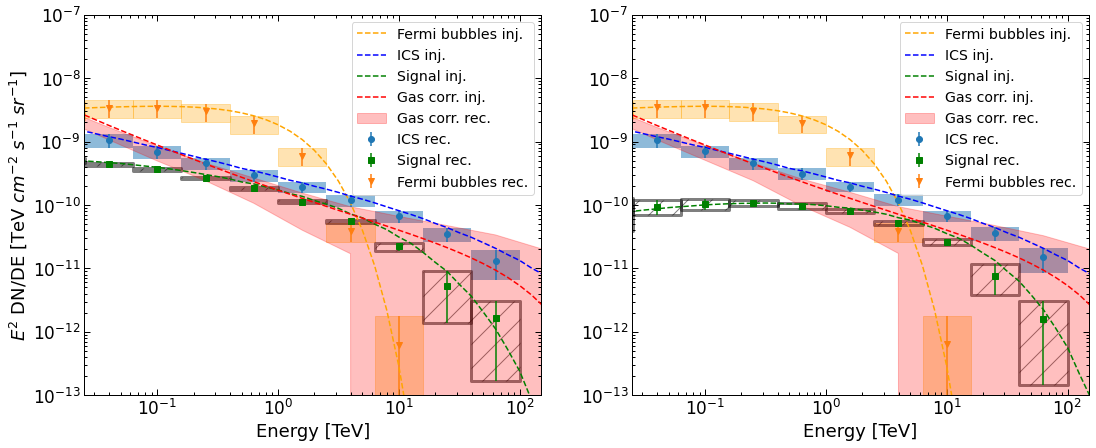

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize = (18,7))


for injection_spectra in range(2):

  all_T = all_T_tot[injection_spectra]
  all_f = all_f_tot[injection_spectra]
  all_f_Std = all_f_Std_tot[injection_spectra]
  all_T_std = all_T_std_tot[injection_spectra]


  total_T = np.sum(all_T, axis = 0)

  for i in range(len(total_T)-1):
    if total_T[i+1] > 41:
      signal_bin = i
      break
  print (total_T[signal_bin])

  if injection_spectra == 1:
    signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
  else:
    signal_strengts = np.logspace(-1.5,1,ss_steps)  
  


  ICS_l = []
  GCE_l = []
  SI_l = []

  ICS_l2 = []
  GCE_l2 = []
  SI_l2 = []
  fermi_l = []

  fermi_flux = []
  for i in range(47):
    I1 = np.mean(ics_ring_maps[0][i]) * energies[i]**2 * 10**6 
    I2 = np.mean(ics_ring_maps[1][i]) * energies[i]**2 * 10**6
    I3 = np.mean(ics_ring_maps[2][i]) * energies[i]**2 * 10**6
    I4 = np.mean(ics_ring_maps[3][i]) * energies[i]**2 * 10**6

    G1 = np.mean(GCE_ring_maps[0][i]) * energies[i]**2 * 10**6
    G2 = np.mean(GCE_ring_maps[1][i]) * energies[i]**2 * 10**6
    G3 = np.mean(GCE_ring_maps[2][i]) * energies[i]**2 * 10**6
    G4 = np.mean(GCE_ring_maps[3][i]) * energies[i]**2 * 10**6

    S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6
    
    fermi_flux.append(np.mean(fermi_binned_min[i]) * energies[i]**2)

    ICS = I1+I2+I3+I4
    GCE = G1+G2+G3+G4
    
    SI_l.append(S1)
    ICS_l.append(ICS)
    GCE_l.append(GCE)


  for energy_bin in range(11):
    j = 2+energy_bin*4

    fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][-2]
    I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
    I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]

    G12 = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
    G22 = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2]
    G32 = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]
    G42 = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
  
    S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]

    fermi_li_e = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f_Std[energy_bin][signal_bin][-2]
    I12_e = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]
    I22_e = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I32_e = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I42_e = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]

    G12_e = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][1]
    G22_e = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][2]
    G32_e = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][3]
    G42_E = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][4]
  
    S1_e = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]



    ICS2 = I12+I22+I32+I42
    GCE2 = G12+G22+G32+G42

    fermi_l.append(fermi_li)
    SI_l2.append(S1)
    ICS_l2.append(ICS2)
    GCE_l2.append(GCE2)

  errorboxes_ICS = []
  errorboxes_signal = []
  errorboxes_fermi = []

  for x,y,ye,dx in zip(energies_bound[:-1], ICS_l2[:-1],ICS_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_ICS.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], SI_l2[:-1],signal_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_signal.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], fermi_l[:-1],fermi_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_fermi.append(rect)



  GCE_l2 = np.array(GCE_l2)
  ICS_error = np.array(ICS_error)
  pc = PatchCollection(errorboxes_ICS, alpha = 0.5, label = "dfsdfs")
  pc1 = PatchCollection(errorboxes_fermi, alpha = 0.3, color = 'orange')
  pc2 = PatchCollection(errorboxes_signal, alpha = 0.5, edgecolor = 'black', facecolor = 'None',linewidth=3,hatch = '/', label = "Signal rec.")

  ax[injection_spectra].add_collection(pc)
  ax[injection_spectra].add_collection(pc1)
  ax[injection_spectra].add_collection(pc2)
  artists = ax[injection_spectra].errorbar(new_energies, ICS_l2, ICS_error, fmt = 'o', label = "ICS rec.",marker = 'o')
  artists = ax[injection_spectra].errorbar(new_energies, SI_l2, signal_error, fmt = 'o', color = 'green',label = "Signal rec.", marker = 's')

  ax[injection_spectra].plot(energies, fermi_flux,  linestyle='--',  color='orange', label = 'Fermi bubbles inj.')

  ax[injection_spectra].plot(energies[1:], ICS_l[1:],  linestyle='--',color='b', label = 'ICS inj.')
  #ax.errorbar(new_energies, ICS_l2,ICS_error,  linestyle='--', marker='^', color='b', label = 'ics',ecolor='y')
  #ax.fill_between(new_energies,ICS_l2 - ICS_error,ICS_l2 + ICS_error, alpha = 0.5) 

  ax[injection_spectra].plot(energies[1:], signal_strengts[signal_bin] * np.array(SI_l)[1:],  linestyle='--',color='g', label = 'Signal inj.')
  #ax.fill_between(new_energies,SI_l2 - signal_error, SI_l2 + signal_error, alpha = 0.5, color= 'g')

  ax[injection_spectra].plot(energies[1:], GCE_l[1:],  linestyle='--', color='r', label = 'Gas corr. inj.')
  #ax.errorbar(new_energies, GCE_l2,GCE_error, color='r',fmt='o',elinewidth = 2, alpha = 1,capsize = 5, capthick = 3, label = 'Gas corr. fit', marker = '^')
  ax[injection_spectra].fill_between(new_energies,GCE_l2 - GCE_error, GCE_l2 + GCE_error, color = 'r', alpha = 0.25, label = 'Gas corr. rec.')

  ax[injection_spectra].errorbar(new_energies,fermi_l,fermi_error, fmt = 'o', marker = 'v', label = 'Fermi bubbles rec.')

  ax[injection_spectra].set_ylim(10**-13,10**-7)
  ax[injection_spectra].set_xlim(0.025,150)
  if injection_spectra == 0:
    ax[injection_spectra].set_ylabel(r'$E^{2}$ DN/DE [TeV $cm^{-2}$ $s^{-1}$ $sr^{-1}]$')
  ax[injection_spectra].set_xlabel(r'Energy [TeV]')
  
  ax[injection_spectra].set_xscale('log')
  ax[injection_spectra].set_yscale('log')
  
  ax[injection_spectra].legend()


plt.show()


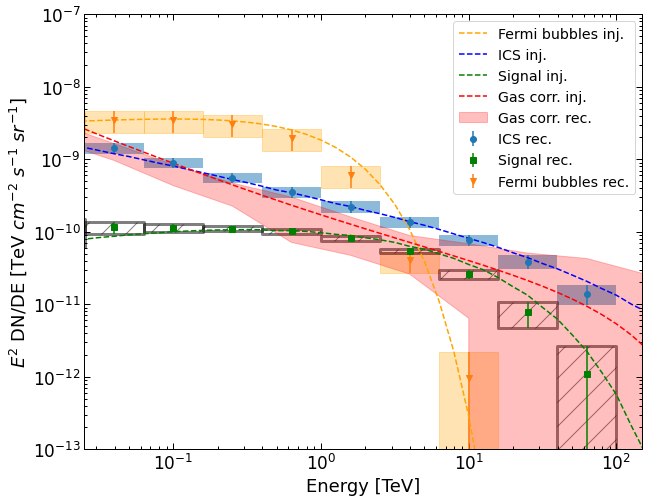

In [ ]:
total_T = np.sum(all_T, axis = 0)


ICS_l = []
GCE_l = []
SI_l = []

ICS_l2 = []
GCE_l2 = []
SI_l2 = []
fermi_l = []

GCE_error = []
ICS_error = []
fermi_error = []
signal_error = []

signal_bin = 8

fermi_flux = []
for i in range(47):
  I1 = np.mean(ics_ring_maps[0][i]) * energies[i]**2 * 10**6 
  I2 = np.mean(ics_ring_maps[1][i]) * energies[i]**2 * 10**6
  I3 = np.mean(ics_ring_maps[2][i]) * energies[i]**2 * 10**6
  I4 = np.mean(ics_ring_maps[3][i]) * energies[i]**2 * 10**6

  G1 = np.mean(GCE_ring_maps[0][i]) * energies[i]**2 * 10**6
  G2 = np.mean(GCE_ring_maps[1][i]) * energies[i]**2 * 10**6
  G3 = np.mean(GCE_ring_maps[2][i]) * energies[i]**2 * 10**6
  G4 = np.mean(GCE_ring_maps[3][i]) * energies[i]**2 * 10**6

  S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6
  
  fermi_flux.append(np.mean(fermi_binned_min[i]) * energies[i]**2)

  ICS = I1+I2+I3+I4
  GCE = G1+G2+G3+G4
  
  SI_l.append(S1)
  ICS_l.append(ICS)
  GCE_l.append(GCE)


for energy_bin in range(11):
  j = 2+energy_bin*4

  fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2
              + np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][-2]
  fermi_li_e = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2
              + np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f_Std[energy_bin][signal_bin][-2]
  I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
  I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
  I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
  I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 
         + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]

  I12_e = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]
  I22_e = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
  I32_e = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2
         + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
  I42_e = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 
         + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]

  G11 = (np.mean(H1_1_binned[j]) * energies[j]**2 + np.mean(H1_1_binned[j+1]) * energies[j+1]**2 + np.mean(H1_1_binned[j+2]) * energies[j+2]**2 
         + np.mean(H1_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
  G12 = (np.mean(H1_2_binned[j]) * energies[j]**2 + np.mean(H1_2_binned[j+1]) * energies[j+1]**2 + np.mean(H1_2_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2]
  G13 = (np.mean(H1_3_binned[j]) * energies[j]**2 + np.mean(H1_3_binned[j+1]) * energies[j+1]**2 + np.mean(H1_3_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]
  G14 = (np.mean(H1_4_binned[j]) * energies[j]**2 + np.mean(H1_4_binned[j+1]) * energies[j+1]**2 + np.mean(H1_4_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
  G21 = (np.mean(H2_1_binned[j]) * energies[j]**2 + np.mean(H2_1_binned[j+1]) * energies[j+1]**2 + np.mean(H2_1_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][5]
  G22 = (np.mean(H2_2_binned[j]) * energies[j]**2 + np.mean(H2_2_binned[j+1]) * energies[j+1]**2 + np.mean(H2_2_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][6]
  G23 = (np.mean(H2_3_binned[j]) * energies[j]**2 + np.mean(H2_3_binned[j+1]) * energies[j+1]**2 + np.mean(H2_3_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][7]
  G24 = (np.mean(H2_4_binned[j]) * energies[j]**2 + np.mean(H2_4_binned[j+1]) * energies[j+1]**2 + np.mean(H2_4_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][8]

  G31 = (np.mean(dust_binned_pos[j]) * energies[j]**2 + np.mean(dust_binned_pos[j+1]) * energies[j+1]**2 + np.mean(dust_binned_pos[j+2]) * energies[j+2]**2
         + np.mean(dust_binned_pos[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]
  G32 = (np.mean(dust_binned_neg[j]) * energies[j]**2 + np.mean(dust_binned_neg[j+1]) * energies[j+1]**2 + np.mean(dust_binned_neg[j+2]) * energies[j+2]**2
         + np.mean(dust_binned_neg[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]

  G11_e = (np.mean(H1_1_binned[j]) * energies[j]**2 + np.mean(H1_1_binned[j+1]) * energies[j+1]**2 + np.mean(H1_1_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][1]
  G12_e = (np.mean(H1_2_binned[j]) * energies[j]**2 + np.mean(H1_2_binned[j+1]) * energies[j+1]**2 + np.mean(H1_2_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][2]
  G13_e = (np.mean(H1_3_binned[j]) * energies[j]**2 + np.mean(H1_3_binned[j+1]) * energies[j+1]**2 + np.mean(H1_3_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][3]
  G14_e = (np.mean(H1_4_binned[j]) * energies[j]**2 + np.mean(H1_4_binned[j+1]) * energies[j+1]**2 + np.mean(H1_4_binned[j+2]) * energies[j+2]**2
         + np.mean(H1_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][4]
  G21_e = (np.mean(H2_1_binned[j]) * energies[j]**2 + np.mean(H2_1_binned[j+1]) * energies[j+1]**2 + np.mean(H2_1_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][5]
  G22_e = (np.mean(H2_2_binned[j]) * energies[j]**2 + np.mean(H2_2_binned[j+1]) * energies[j+1]**2 + np.mean(H2_2_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][6]
  G23_e = (np.mean(H2_3_binned[j]) * energies[j]**2 + np.mean(H2_3_binned[j+1]) * energies[j+1]**2 + np.mean(H2_3_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][7]
  G24_e = (np.mean(H2_4_binned[j]) * energies[j]**2 + np.mean(H2_4_binned[j+1]) * energies[j+1]**2 + np.mean(H2_4_binned[j+2]) * energies[j+2]**2
         + np.mean(H2_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][8]

  G31_e = (np.mean(dust_binned_pos[j]) * energies[j]**2 + np.mean(dust_binned_pos[j+1]) * energies[j+1]**2 + np.mean(dust_binned_pos[j+2]) * energies[j+2]**2
         + np.mean(dust_binned_pos[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][9]
  G32_e = (np.mean(dust_binned_neg[j]) * energies[j]**2 + np.mean(dust_binned_neg[j+1]) * energies[j+1]**2 + np.mean(dust_binned_neg[j+2]) * energies[j+2]**2
         + np.mean(dust_binned_neg[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][9]




  fermi_l.append(fermi_li)
  S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2
        + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]
  S1_e = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2
        + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][-1]



  ICS2 = I12+I22+I32+I42
  GCE2 = G12+G12+G13+G14+G21+G22+G23+G24+G31+G32

  
  GCE_e_tot = G12_e+G12_e+G13_e+G14_e+G21_e+G22_e+G23_e+G24_e+G31_e+G32_e
  ICS_e_tot = I12_e + I22_e + I32_e + I42_e
  
  GCE_error.append(GCE_e_tot)
  ICS_error.append(ICS_e_tot)
  fermi_error.append(fermi_li_e)
  signal_error.append(S1_e)

  SI_l2.append(S1)
  ICS_l2.append(ICS2)
  GCE_l2.append(GCE2)

GCE_l2 = np.array(GCE_l2)
ICS_error = np.array(ICS_error)
error_low  = GCE_l2[:-1] - GCE_error[:-1]
energies_bound = [energies[4*i] for i in range(12)]


fig = plt.figure(figsize=[10, 8])
ax = plt.subplot()

errorboxes_ICS = []
errorboxes_signal = []
errorboxes_fermi = []

for x,y,ye,dx in zip(energies_bound[:-1], ICS_l2[:-1],ICS_error[:-1], energies_bound[1:]):
  x2 = dx - x
  rect = Rectangle((x, y - ye), x2, 2*ye)
  errorboxes_ICS.append(rect)

for x,y,ye,dx in zip(energies_bound[:-1], SI_l2[:-1],signal_error[:-1], energies_bound[1:]):
  x2 = dx - x
  rect = Rectangle((x, y - ye), x2, 2*ye)
  errorboxes_signal.append(rect)

for x,y,ye,dx in zip(energies_bound[:-1], fermi_l[:-1],fermi_error[:-1], energies_bound[1:]):
  x2 = dx - x
  rect = Rectangle((x, y - ye), x2, 2*ye)
  errorboxes_fermi.append(rect)




pc = PatchCollection(errorboxes_ICS, alpha = 0.5, label = "dfsdfs")
pc1 = PatchCollection(errorboxes_fermi, alpha = 0.3, color = 'orange')
pc2 = PatchCollection(errorboxes_signal, alpha = 0.5, edgecolor = 'black', facecolor = 'None',linewidth=3,hatch = '/', label = "Signal rec.")

ax.add_collection(pc)
ax.add_collection(pc1)
ax.add_collection(pc2)
artists = ax.errorbar(new_energies, ICS_l2, ICS_error, fmt = 'o', label = "ICS rec.",marker = 'o')
artists = ax.errorbar(new_energies, SI_l2, signal_error, fmt = 'o', color = 'green',label = "Signal rec.", marker = 's')

ax.plot(energies, fermi_flux,  linestyle='--',  color='orange', label = 'Fermi bubbles inj.')

ax.plot(energies[1:], ICS_l[1:],  linestyle='--',color='b', label = 'ICS inj.')
#ax.errorbar(new_energies, ICS_l2,ICS_error,  linestyle='--', marker='^', color='b', label = 'ics',ecolor='y')
#ax.fill_between(new_energies,ICS_l2 - ICS_error,ICS_l2 + ICS_error, alpha = 0.5) 

ax.plot(energies[1:], signal_strengts[signal_bin] * np.array(SI_l)[1:],  linestyle='--',color='g', label = 'Signal inj.')
#ax.fill_between(new_energies,SI_l2 - signal_error, SI_l2 + signal_error, alpha = 0.5, color= 'g')

ax.plot(energies[1:], GCE_l[1:],  linestyle='--', color='r', label = 'Gas corr. inj.')
#ax.errorbar(new_energies, GCE_l2,GCE_error, color='r',fmt='o',elinewidth = 2, alpha = 1,capsize = 5, capthick = 3, label = 'Gas corr. fit', marker = '^')
ax.fill_between(new_energies,GCE_l2 - GCE_error, GCE_l2 + GCE_error, color = 'r', alpha = 0.25, label = 'Gas corr. rec.')

ax.errorbar(new_energies,fermi_l,fermi_error, fmt = 'o', marker = 'v', label = 'Fermi bubbles rec.')

ax.set_ylim(10**-13,10**-7)
ax.set_xlim(0.025,150)
ax.set_ylabel(r'$E^{2}$ DN/DE [TeV $cm^{-2}$ $s^{-1}$ $sr^{-1}]$')
ax.set_xlabel(r'Energy [TeV]')
plt.legend()
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()


37.852166122110134
33.13348404084503
40.78082146023085
36.36833502182629


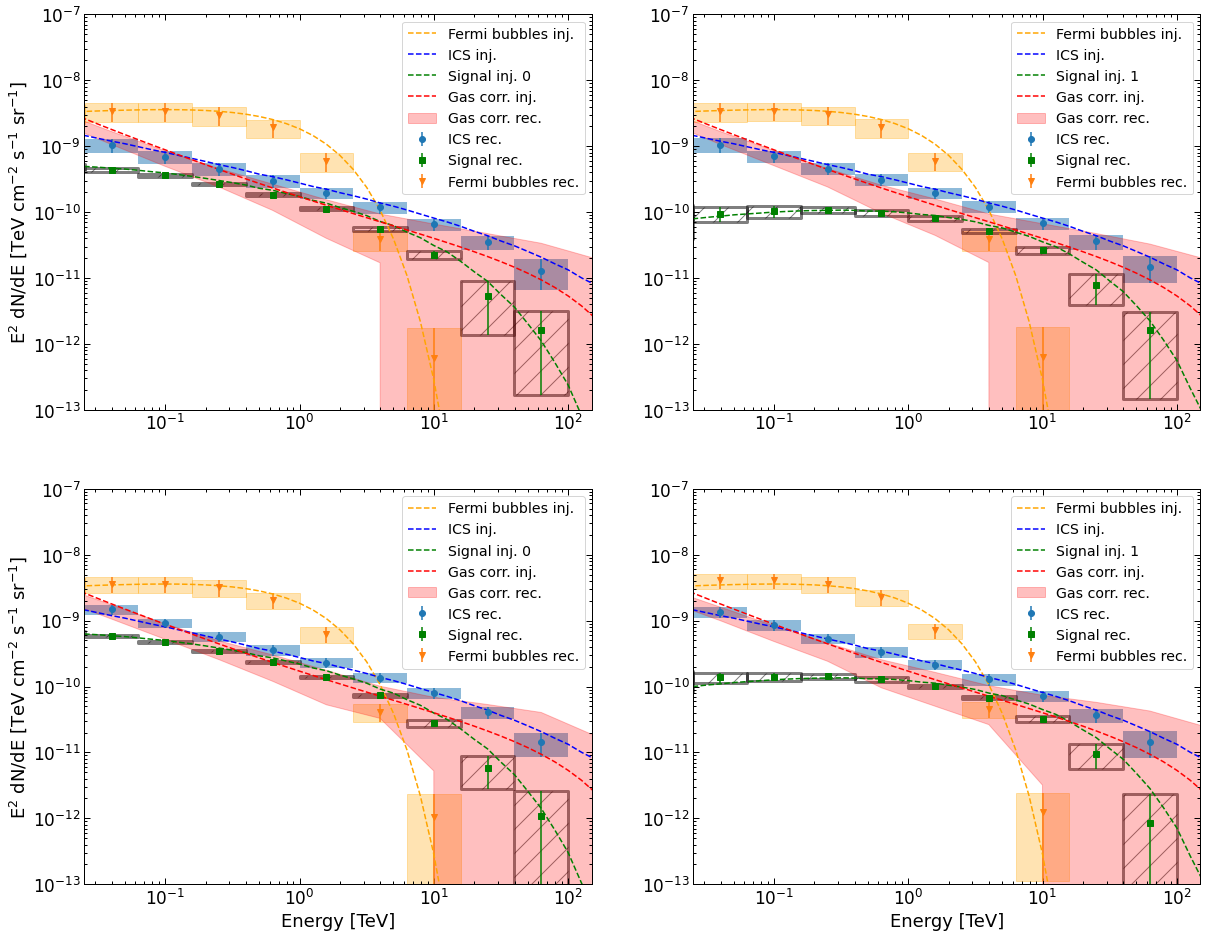

In [ ]:
fig,ax = plt.subplots(2,2,figsize = (20,16))

for injection_spectra in range(2):

  all_T = all_T_tot[injection_spectra]
  all_f = all_f_tot[injection_spectra]
  all_f_Std = all_f_Std_tot[injection_spectra]
  all_T_std = all_T_std_tot[injection_spectra]


  total_T = np.sum(all_T, axis = 0)

  for i in range(len(total_T)-1):
    if total_T[i+1] > 41:
      signal_bin = i
      break
  print (total_T[signal_bin])

  if injection_spectra == 1:
    signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
  else:
    signal_strengts = np.logspace(-1.5,1,ss_steps)  
  


  ICS_l = []
  GCE_l = []
  SI_l = []

  ICS_l2 = []
  GCE_l2 = []
  SI_l2 = []
  fermi_l = []

  fermi_flux = []
  for i in range(47):
    I1 = np.mean(ics_ring_maps[0][i]) * energies[i]**2 * 10**6 
    I2 = np.mean(ics_ring_maps[1][i]) * energies[i]**2 * 10**6
    I3 = np.mean(ics_ring_maps[2][i]) * energies[i]**2 * 10**6
    I4 = np.mean(ics_ring_maps[3][i]) * energies[i]**2 * 10**6

    G1 = np.mean(GCE_ring_maps[0][i]) * energies[i]**2 * 10**6
    G2 = np.mean(GCE_ring_maps[1][i]) * energies[i]**2 * 10**6
    G3 = np.mean(GCE_ring_maps[2][i]) * energies[i]**2 * 10**6
    G4 = np.mean(GCE_ring_maps[3][i]) * energies[i]**2 * 10**6

    S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6
    
    fermi_flux.append(np.mean(fermi_binned_min[i]) * energies[i]**2)

    ICS = I1+I2+I3+I4
    GCE = G1+G2+G3+G4
    
    SI_l.append(S1)
    ICS_l.append(ICS)
    GCE_l.append(GCE)


  for energy_bin in range(11):
    j = 2+energy_bin*4

    fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][-2]
    I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
    I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]

    G12 = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
    G22 = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2]
    G32 = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]
    G42 = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
  
    S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]

    fermi_li_e = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2+ np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f_Std[energy_bin][signal_bin][-2]
    I12_e = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]
    I22_e = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I32_e = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I42_e = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]

    G12_e = (np.mean(GCE_ring_maps[0][j]) * energies[j]**2 + np.mean(GCE_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[0][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][1]
    G22_e = (np.mean(GCE_ring_maps[1][j]) * energies[j]**2 + np.mean(GCE_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[1][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][2]
    G32_e = (np.mean(GCE_ring_maps[2][j]) * energies[j]**2 + np.mean(GCE_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[2][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][3]
    G42_E = (np.mean(GCE_ring_maps[3][j]) * energies[j]**2 + np.mean(GCE_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(GCE_ring_maps[3][j+2]) * energies[j+2]**2 + np.mean(GCE_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][4]
  
    S1_e = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2 + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]



    ICS2 = I12+I22+I32+I42
    GCE2 = G12+G22+G32+G42

    fermi_l.append(fermi_li)
    SI_l2.append(S1)
    ICS_l2.append(ICS2)
    GCE_l2.append(GCE2)

  errorboxes_ICS = []
  errorboxes_signal = []
  errorboxes_fermi = []

  for x,y,ye,dx in zip(energies_bound[:-1], ICS_l2[:-1],ICS_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_ICS.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], SI_l2[:-1],signal_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_signal.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], fermi_l[:-1],fermi_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_fermi.append(rect)



  GCE_l2 = np.array(GCE_l2)
  ICS_error = np.array(ICS_error)
  pc = PatchCollection(errorboxes_ICS, alpha = 0.5, label = "dfsdfs")
  pc1 = PatchCollection(errorboxes_fermi, alpha = 0.3, color = 'orange')
  pc2 = PatchCollection(errorboxes_signal, alpha = 0.5, edgecolor = 'black', facecolor = 'None',linewidth=3,hatch = '/', label = "Signal rec.")

  ax[0][injection_spectra].add_collection(pc)
  ax[0][injection_spectra].add_collection(pc1)
  ax[0][injection_spectra].add_collection(pc2)
  artists = ax[0][injection_spectra].errorbar(new_energies, ICS_l2, ICS_error, fmt = 'o', label = "ICS rec.",marker = 'o')
  artists = ax[0][injection_spectra].errorbar(new_energies, SI_l2, signal_error, fmt = 'o', color = 'green',label = "Signal rec.", marker = 's')

  ax[0][injection_spectra].plot(energies, fermi_flux,  linestyle='--',  color='orange', label = 'Fermi bubbles inj.')

  ax[0][injection_spectra].plot(energies[1:], ICS_l[1:],  linestyle='--',color='b', label = 'ICS inj.')
  #ax.errorbar(new_energies, ICS_l2,ICS_error,  linestyle='--', marker='^', color='b', label = 'ics',ecolor='y')
  #ax.fill_between(new_energies,ICS_l2 - ICS_error,ICS_l2 + ICS_error, alpha = 0.5) 

  ax[0][injection_spectra].plot(energies[1:], signal_strengts[signal_bin] * np.array(SI_l)[1:],  linestyle='--',color='g', label = f'Signal inj. {injection_spectra}')
  #ax.fill_between(new_energies,SI_l2 - signal_error, SI_l2 + signal_error, alpha = 0.5, color= 'g')

  ax[0][injection_spectra].plot(energies[1:], GCE_l[1:],  linestyle='--', color='r', label = 'Gas corr. inj.')
  #ax.errorbar(new_energies, GCE_l2,GCE_error, color='r',fmt='o',elinewidth = 2, alpha = 1,capsize = 5, capthick = 3, label = 'Gas corr. fit', marker = '^')
  ax[0][injection_spectra].fill_between(new_energies,GCE_l2 - GCE_error, GCE_l2 + GCE_error, color = 'r', alpha = 0.25, label = 'Gas corr. rec.')

  ax[0][injection_spectra].errorbar(new_energies,fermi_l,fermi_error, fmt = 'o', marker = 'v', label = 'Fermi bubbles rec.')

  ax[0][injection_spectra].set_ylim(10**-13,10**-7)
  ax[0][injection_spectra].set_xlim(0.025,150)
  if injection_spectra == 0:
    ax[0][injection_spectra].set_ylabel(r'E$^{2}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$ sr$^{-1}]$')
#  ax[0][injection_spectra].set_xlabel(r'Energy [TeV]')
  
  ax[0][injection_spectra].set_xscale('log')
  ax[0][injection_spectra].set_yscale('log')
  
  ax[0][injection_spectra].legend()



for injection_spectra in range(2):

  all_T = all_T_tot_mis[injection_spectra]
  all_f = all_f_tot_mis[injection_spectra]
  all_f_Std = all_f_Std_tot_mis[injection_spectra]
  all_T_std = all_T_std_tot_mis[injection_spectra]

  if injection_spectra == 1:
    signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
  else:
    signal_strengts = np.logspace(-1.5,1,ss_steps)  

  total_T = np.sum(all_T, axis = 0)

  ICS_l = []
  GCE_l = []
  SI_l = []

  ICS_l2 = []
  GCE_l2 = []
  SI_l2 = []
  fermi_l = []

  GCE_error = []
  ICS_error = []
  fermi_error = []
  signal_error = []

  for i in range(len(total_T)-1):
    if total_T[i+1] > 41:
      signal_bin = i
      break
      

  print (total_T[signal_bin])

  fermi_flux = []
  for i in range(47):
    I1 = np.mean(ics_ring_maps[0][i]) * energies[i]**2 * 10**6 
    I2 = np.mean(ics_ring_maps[1][i]) * energies[i]**2 * 10**6
    I3 = np.mean(ics_ring_maps[2][i]) * energies[i]**2 * 10**6
    I4 = np.mean(ics_ring_maps[3][i]) * energies[i]**2 * 10**6

    G1 = np.mean(GCE_ring_maps[0][i]) * energies[i]**2 * 10**6
    G2 = np.mean(GCE_ring_maps[1][i]) * energies[i]**2 * 10**6
    G3 = np.mean(GCE_ring_maps[2][i]) * energies[i]**2 * 10**6
    G4 = np.mean(GCE_ring_maps[3][i]) * energies[i]**2 * 10**6

    S1 = np.mean((signals[injection_spectra][i])) * energies[i]**2 * 10**6
    
    fermi_flux.append(np.mean(fermi_binned_min[i]) * energies[i]**2)

    ICS = I1+I2+I3+I4
    GCE = G1+G2+G3+G4
    
    SI_l.append(S1)
    ICS_l.append(ICS)
    GCE_l.append(GCE)


  for energy_bin in range(11):
    j = 2+energy_bin*4

    fermi_li = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2
                + np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f[energy_bin][signal_bin][-2]
    fermi_li_e = (np.mean(fermi_binned_min[j]) * energies[j]**2 + np.mean(fermi_binned_min[j+1]) * energies[j+1]**2+ np.mean(fermi_binned_min[j+2])* energies[j+2]**2
                + np.mean(fermi_binned_min[j+3])* energies[j+3]**2) / 4 * all_f_Std[energy_bin][signal_bin][-2]
    I12 = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]
    I22 = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I32 = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0] 
    I42 = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 
          + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][0]

    I12_e = (np.mean(ics_ring_maps[0][j]) * energies[j]**2 + np.mean(ics_ring_maps[0][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[0][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[0][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]
    I22_e = (np.mean(ics_ring_maps[1][j]) * energies[j]**2 + np.mean(ics_ring_maps[1][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[1][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[1][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I32_e = (np.mean(ics_ring_maps[2][j]) * energies[j]**2 + np.mean(ics_ring_maps[2][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[2][j+2]) * energies[j+2]**2
          + np.mean(ics_ring_maps[2][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0] 
    I42_e = (np.mean(ics_ring_maps[3][j]) * energies[j]**2 + np.mean(ics_ring_maps[3][j+1]) * energies[j+1]**2 + np.mean(ics_ring_maps[3][j+2]) * energies[j+2]**2 
          + np.mean(ics_ring_maps[3][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][0]

    G11 = (np.mean(H1_1_binned[j]) * energies[j]**2 + np.mean(H1_1_binned[j+1]) * energies[j+1]**2 + np.mean(H1_1_binned[j+2]) * energies[j+2]**2 
          + np.mean(H1_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][1]
    G12 = (np.mean(H1_2_binned[j]) * energies[j]**2 + np.mean(H1_2_binned[j+1]) * energies[j+1]**2 + np.mean(H1_2_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][2]
    G13 = (np.mean(H1_3_binned[j]) * energies[j]**2 + np.mean(H1_3_binned[j+1]) * energies[j+1]**2 + np.mean(H1_3_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][3]
    G14 = (np.mean(H1_4_binned[j]) * energies[j]**2 + np.mean(H1_4_binned[j+1]) * energies[j+1]**2 + np.mean(H1_4_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][4]
    G21 = (np.mean(H2_1_binned[j]) * energies[j]**2 + np.mean(H2_1_binned[j+1]) * energies[j+1]**2 + np.mean(H2_1_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][5]
    G22 = (np.mean(H2_2_binned[j]) * energies[j]**2 + np.mean(H2_2_binned[j+1]) * energies[j+1]**2 + np.mean(H2_2_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][6]
    G23 = (np.mean(H2_3_binned[j]) * energies[j]**2 + np.mean(H2_3_binned[j+1]) * energies[j+1]**2 + np.mean(H2_3_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][7]
    G24 = (np.mean(H2_4_binned[j]) * energies[j]**2 + np.mean(H2_4_binned[j+1]) * energies[j+1]**2 + np.mean(H2_4_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][8]

    G31 = (np.mean(dust_binned_pos[j]) * energies[j]**2 + np.mean(dust_binned_pos[j+1]) * energies[j+1]**2 + np.mean(dust_binned_pos[j+2]) * energies[j+2]**2
          + np.mean(dust_binned_pos[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]
    G32 = (np.mean(dust_binned_neg[j]) * energies[j]**2 + np.mean(dust_binned_neg[j+1]) * energies[j+1]**2 + np.mean(dust_binned_neg[j+2]) * energies[j+2]**2
          + np.mean(dust_binned_neg[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][9]

    G11_e = (np.mean(H1_1_binned[j]) * energies[j]**2 + np.mean(H1_1_binned[j+1]) * energies[j+1]**2 + np.mean(H1_1_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][1]
    G12_e = (np.mean(H1_2_binned[j]) * energies[j]**2 + np.mean(H1_2_binned[j+1]) * energies[j+1]**2 + np.mean(H1_2_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][2]
    G13_e = (np.mean(H1_3_binned[j]) * energies[j]**2 + np.mean(H1_3_binned[j+1]) * energies[j+1]**2 + np.mean(H1_3_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][3]
    G14_e = (np.mean(H1_4_binned[j]) * energies[j]**2 + np.mean(H1_4_binned[j+1]) * energies[j+1]**2 + np.mean(H1_4_binned[j+2]) * energies[j+2]**2
          + np.mean(H1_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][4]
    G21_e = (np.mean(H2_1_binned[j]) * energies[j]**2 + np.mean(H2_1_binned[j+1]) * energies[j+1]**2 + np.mean(H2_1_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_1_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][5]
    G22_e = (np.mean(H2_2_binned[j]) * energies[j]**2 + np.mean(H2_2_binned[j+1]) * energies[j+1]**2 + np.mean(H2_2_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_2_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][6]
    G23_e = (np.mean(H2_3_binned[j]) * energies[j]**2 + np.mean(H2_3_binned[j+1]) * energies[j+1]**2 + np.mean(H2_3_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_3_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][7]
    G24_e = (np.mean(H2_4_binned[j]) * energies[j]**2 + np.mean(H2_4_binned[j+1]) * energies[j+1]**2 + np.mean(H2_4_binned[j+2]) * energies[j+2]**2
          + np.mean(H2_4_binned[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][8]

    G31_e = (np.mean(dust_binned_pos[j]) * energies[j]**2 + np.mean(dust_binned_pos[j+1]) * energies[j+1]**2 + np.mean(dust_binned_pos[j+2]) * energies[j+2]**2
          + np.mean(dust_binned_pos[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][9]
    G32_e = (np.mean(dust_binned_neg[j]) * energies[j]**2 + np.mean(dust_binned_neg[j+1]) * energies[j+1]**2 + np.mean(dust_binned_neg[j+2]) * energies[j+2]**2
          + np.mean(dust_binned_neg[j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][9]




    fermi_l.append(fermi_li)
    S1 = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2
          + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f[energy_bin][signal_bin][-1]
    S1_e = (np.mean(signals[injection_spectra][j]) * energies[j]**2 + np.mean(signals[injection_spectra][j+1]) * energies[j+1]**2 + np.mean(signals[injection_spectra][j+2]) * energies[j+2]**2
          + np.mean(signals[injection_spectra][j+3]) * energies[j+3]**2) /4  * 10**6 * all_f_Std[energy_bin][signal_bin][-1]



    ICS2 = I12+I22+I32+I42
    GCE2 = G12+G12+G13+G14+G21+G22+G23+G24+G31+G32

    
    GCE_e_tot = G12_e+G12_e+G13_e+G14_e+G21_e+G22_e+G23_e+G24_e+G31_e+G32_e
    ICS_e_tot = I12_e + I22_e + I32_e + I42_e
    
    GCE_error.append(GCE_e_tot)
    ICS_error.append(ICS_e_tot)
    fermi_error.append(fermi_li_e)
    signal_error.append(S1_e)

    SI_l2.append(S1)
    ICS_l2.append(ICS2)
    GCE_l2.append(GCE2)

  GCE_l2 = np.array(GCE_l2)
  ICS_error = np.array(ICS_error)
  error_low  = GCE_l2[:-1] - GCE_error[:-1]
  energies_bound = [energies[4*i] for i in range(12)]



  errorboxes_ICS = []
  errorboxes_signal = []
  errorboxes_fermi = []

  for x,y,ye,dx in zip(energies_bound[:-1], ICS_l2[:-1],ICS_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_ICS.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], SI_l2[:-1],signal_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_signal.append(rect)

  for x,y,ye,dx in zip(energies_bound[:-1], fermi_l[:-1],fermi_error[:-1], energies_bound[1:]):
    x2 = dx - x
    rect = Rectangle((x, y - ye), x2, 2*ye)
    errorboxes_fermi.append(rect)




  pc = PatchCollection(errorboxes_ICS, alpha = 0.5, label = "dfsdfs")
  pc1 = PatchCollection(errorboxes_fermi, alpha = 0.3, color = 'orange')
  pc2 = PatchCollection(errorboxes_signal, alpha = 0.5, edgecolor = 'black', facecolor = 'None',linewidth=3,hatch = '/', label = "Signal rec.")

  ax[1][injection_spectra].add_collection(pc)
  ax[1][injection_spectra].add_collection(pc1)
  ax[1][injection_spectra].add_collection(pc2)
  artists = ax[1][injection_spectra].errorbar(new_energies, ICS_l2, ICS_error, fmt = 'o', label = "ICS rec.",marker = 'o')
  artists = ax[1][injection_spectra].errorbar(new_energies, SI_l2, signal_error, fmt = 'o', color = 'green',label = "Signal rec.", marker = 's')

  ax[1][injection_spectra].plot(energies, fermi_flux,  linestyle='--',  color='orange', label = 'Fermi bubbles inj.')

  ax[1][injection_spectra].plot(energies[1:], ICS_l[1:],  linestyle='--',color='b', label = 'ICS inj.')
  #ax.errorbar(new_energies, ICS_l2,ICS_error,  linestyle='--', marker='^', color='b', label = 'ics',ecolor='y')
  #ax.fill_between(new_energies,ICS_l2 - ICS_error,ICS_l2 + ICS_error, alpha = 0.5) 

  ax[1][injection_spectra].plot(energies[1:], signal_strengts[signal_bin] * np.array(SI_l)[1:],  linestyle='--',color='g', label = f'Signal inj. {injection_spectra}')
  #ax.fill_between(new_energies,SI_l2 - signal_error, SI_l2 + signal_error, alpha = 0.5, color= 'g')

  ax[1][injection_spectra].plot(energies[1:], GCE_l[1:],  linestyle='--', color='r', label = 'Gas corr. inj.')
  #ax.errorbar(new_energies, GCE_l2,GCE_error, color='r',fmt='o',elinewidth = 2, alpha = 1,capsize = 5, capthick = 3, label = 'Gas corr. fit', marker = '^')
  ax[1][injection_spectra].fill_between(new_energies,GCE_l2 - GCE_error, GCE_l2 + GCE_error, color = 'r', alpha = 0.25, label = 'Gas corr. rec.')

  ax[1][injection_spectra].errorbar(new_energies,fermi_l,fermi_error, fmt = 'o', marker = 'v', label = 'Fermi bubbles rec.')

  ax[1][injection_spectra].set_ylim(10**-13,10**-7)
  ax[1][injection_spectra].set_xlim(0.025,150)
  if injection_spectra == 0:
    ax[1][injection_spectra].set_ylabel(r'E$^{2}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$ sr$^{-1}]$')
  ax[1][injection_spectra].set_xlabel(r'Energy [TeV]')
  
  ax[1][injection_spectra].set_xscale('log')
  ax[1][injection_spectra].set_yscale('log')
  ax[1][injection_spectra].legend()



plt.savefig('All_fluxes.pdf', bbox_inches = "tight")

plt.show()


In [ ]:
injection_spectra = 1


all_T = all_T_tot_mis[injection_spectra]
all_f = all_f_tot_mis[injection_spectra]
all_f_Std = all_f_Std_tot_mis[injection_spectra]
all_T_std = all_T_std_tot_mis[injection_spectra]

if injection_spectra == 1:
  signal_strengts = np.logspace(-1.8,0.65,ss_steps)  
else:
  signal_strengts = np.logspace(-1.5,1,ss_steps)  
  

The plot for MC = 30 and injection spectra 1


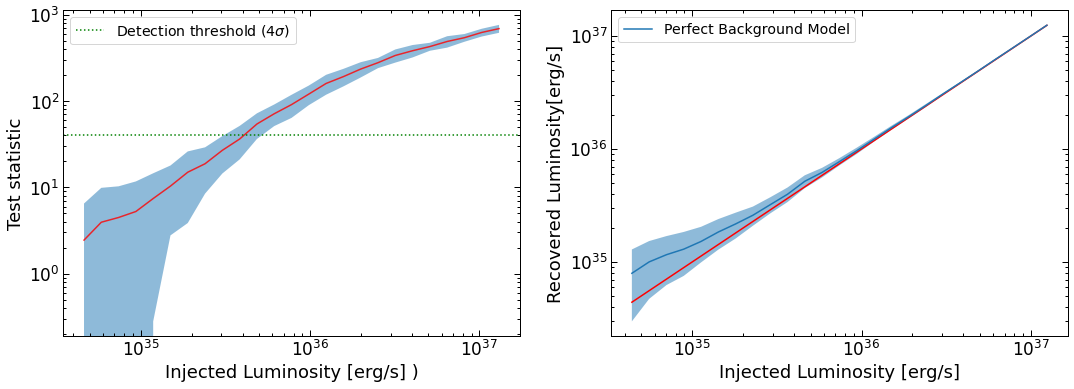

In [ ]:
##### Get the extracted signal normalisations per energy bin and its error #######
extracted = []
error = []
for i in all_f:
  a = [x[-1] for x in i]
  extracted.append(a)

for i in all_f_Std:
  a = [x[-1] for x in i]
  error.append(a)

extracted = np.array(extracted)
error = np.array(error)

####### Converting to 11 energy bins #######
a = signals[injection_spectra]
signal_per_new_bin = []
for i in range(11):
  j = 2+4*i
  signal_per_new_bin.append(np.sum(a[j]) + np.sum(a[j+1]) + np.sum(a[j+2])+ np.sum(a[j+3]))



####### Converting to Luminosity #######
erg = 1.602
total_T = np.sum(all_T, axis = 0)
error_T = np.sum(all_T_std, axis = 0)
signal_signal_per_new_bin = []
range_oi = 10*10 * (np.pi/180)**2

for i in range(46):
  signal_signal_per_new_bin.append(np.mean(signals[injection_spectra][i])*(energies[i+1] - energies[i]) * 10**6 * range_oi * (energies[i+1] * energies[i])**0.5 * erg * 4 * np.pi * Sun_to_centrum**2 )

#### Total signal
signal = np.sum(signal_signal_per_new_bin)
#### In 11 energy bins
signal_per_new_bin = [np.sum(signal_signal_per_new_bin[2 + 4*i:4*i+6]) for i in range(11)]


#### multiplying the signal with the normalisation factors #####
total_injected = np.sum([signal_strengts * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
total_recovered = np.sum([extracted[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)
tot_error = np.sum([error[i] * signal_per_new_bin[i] for i in range(11)] ,axis = 0)



print (f"The plot for MC = {MC_times} and injection spectra {injection_spectra}")
fig,[ax,ax1] = plt.subplots(1,2,figsize= (18,6)) 

ax.plot(signal_strengts * signal, total_T, color = 'red', alpha = 0.8)
ax.fill_between(signal_strengts * signal, total_T-error_T, total_T+error_T, alpha = 0.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(41, linestyle = ':', color = 'g', label = "Detection threshold ($4\sigma$)")
ax.set_xlabel(r'Injected Luminosity [erg/s] )')
ax.set_ylabel('Test statistic')
ax.legend()

ax1.plot(total_injected,total_injected, color = 'r')
ax1.plot(total_injected,total_recovered, label = 'Perfect Background Model')
ax1.fill_between(total_injected, (total_recovered - tot_error), (total_recovered + tot_error), alpha = 0.5)
ax1.set(yscale ='log', xscale = 'log')
ax1.set_xlabel(r'Injected Luminosity [erg/s]')
ax1.set_ylabel(r'Recovered Luminosity[erg/s]')
#ax1.set_ylim(33,37)
ax1.legend()

plt.savefig(f"TS_{injection_spectra}.pdf",bbox_inches='tight')

plt.show()